## Over-representation analyses using MAST DE genes

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os, sys, string
import seaborn as sns
import gseapy as gp
import anndata
from scipy.io import mmwrite

from collections import Counter

from typing import Tuple, Union, List, Dict, Callable
import os
import gzip
import shutil
import inspect
import h5py
import matplotlib

import matplotlib.pyplot as plt
sc.set_figure_params(vector_friendly=False, fontsize=18)

%matplotlib inline

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
home      = "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/"
datahome  = home+ "data/"
cystichome= datahome+"Cystic_signature/"
resulthome= home+ "results/"
dehome    = resulthome+"DE/"
orgdehome = resulthome+"DiffExpr_tubuloid_all/"

markerhome         = datahome +"marker_genes/"
seurat_marker_home = resulthome+"marker_genes/"

mast_human_de_home     = resulthome+"MASTde_3xADPKD/"
mast_human_org_de_home = resulthome+"DiffExpr_tubuloid_all/"

gseahome  = "/Users/noamibrahimhayat/Documents/Aachen/projects/gsea/"

In [4]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return round(float(intersection) / union, 2)

In [5]:
## read data
input_filename = "S_prepared.h5ad"
adata = sc.read_h5ad(datahome + input_filename)

In [6]:
adata

AnnData object with n_obs × n_vars = 26509 × 24504
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Dissociation', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'seurat_clusters', 'init_assign', 'final_Ident', 'lab', 'orig.ident2', 'final_Ident2', 'ident', 'cluster_name', 'scrublet', 'treatment'
    uns: 'Phase_colors', 'X_name', 'cluster_name_colors', 'ident_colors', 'orig.ident2_colors', 'orig.ident_colors', 'rank_genes_groupscluster_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'

In [7]:
tmp_adata = adata.copy()

sc.pp.normalize_total(tmp_adata, target_sum=1e4)
sc.pp.log1p(tmp_adata)
sc.pp.scale(tmp_adata, max_value=10)

## Get orgnoids DE genes

In [8]:
os.system("ls " + orgdehome+"*.csv > " + resulthome+"mast.txt")

0

In [9]:
filenames = pd.read_table(resulthome + "mast.txt", header=None)

myfiles = filenames[0].values.tolist()

frames = []

for filename in myfiles:
    if filename.find("JX2") > 0: continue
    if filename.find("JX3") > 0: continue
    if filename.find("3xADPKD") > 0: continue
    file_id = filename.split("/")[-1].split(".csv")[0]
    
    print(filename)

    tmp_df = pd.read_table(filename, sep=",")
    
    tmp_df["file_id"] = file_id
    #print(tmp_df)
    frames.append(tmp_df)

/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/DiffExpr_tubuloid_all/DiffExpr_2xPKDorganoid_PT_4.csv
/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/DiffExpr_tubuloid_all/DiffExpr_2xPKDorganoid_TAL_2.csv


In [10]:
organoid_df = pd.concat(frames)

In [11]:
organoid_df.rename(columns={'Unnamed: 0':'Gene', 'file_id':'cluster_name'}, inplace=True)

In [12]:
organoid_df["cell_id"]   = organoid_df["cluster_name"].str.split("organoid_").str[1]
organoid_df["comparison"]= organoid_df["cluster_name"].str.split("organoid_").str[0]
#organoid_df.rename(columns={"gene":"Gene"}, inplace=True)
#organoid_df.drop(["cluster_name"], axis=1, inplace=True)

In [13]:
organoid_df.head()

,Gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster_name,cell_id,comparison
0,RACK1,2.050826e-265,2.848747,0.961,0.0,4.564727e-261,DiffExpr_2xPKDorganoid_PT_4,PT_4,DiffExpr_2xPKD
1,ATP5IF1,1.773413e-246,2.263063,0.912,0.0,3.947262e-242,DiffExpr_2xPKDorganoid_PT_4,PT_4,DiffExpr_2xPKD
2,ATP5F1E,9.843510e-244,2.233953,0.904,0.0,2.190969e-239,DiffExpr_2xPKDorganoid_PT_4,PT_4,DiffExpr_2xPKD
3,ATP5MC2,2.885811e-236,2.187722,0.884,0.0,6.423238e-232,DiffExpr_2xPKDorganoid_PT_4,PT_4,DiffExpr_2xPKD
4,ELOB,1.418129e-231,1.946112,0.871,0.0,3.156471e-227,DiffExpr_2xPKDorganoid_PT_4,PT_4,DiffExpr_2xPKD


<Figure size 216x144 with 0 Axes>

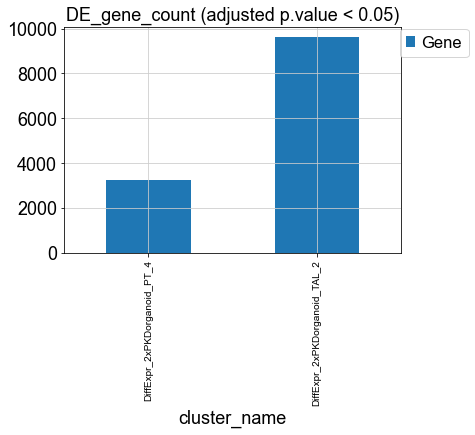

In [14]:
de_count_df = organoid_df[organoid_df["p_val_adj"]<0.05]\
[["Gene", "cluster_name"]].groupby("cluster_name")["Gene"].count().reset_index()

if 1:
    f = plt.figure(figsize = (3,2))
    ax = de_count_df.plot.bar(x='cluster_name', y='Gene', rot=90)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    #ax.set_ylim(0,.4)
    ax.set_title('DE_gene_count (adjusted p.value < 0.05)')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, size=10)
    plt.legend(bbox_to_anchor=(1.2,0.99), loc='upper right', ncol=1, borderaxespad=0)
    plt.savefig('Kidney_organoid_de_count.pdf', bbox_inches='tight')

<Figure size 216x144 with 0 Axes>

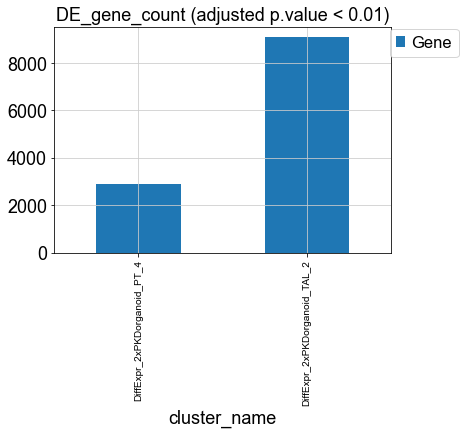

In [15]:
de_count_df = organoid_df[organoid_df["p_val_adj"]<0.01]\
[["Gene", "cluster_name"]].groupby("cluster_name")["Gene"].count().reset_index()

if 1:
    f = plt.figure(figsize = (3,2))
    ax = de_count_df.plot.bar(x='cluster_name', y='Gene', rot=90)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    #ax.set_ylim(0,.4)
    ax.set_title('DE_gene_count (adjusted p.value < 0.01)')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, size=10)
    plt.legend(bbox_to_anchor=(1.2,0.99), loc='upper right', ncol=1, borderaxespad=0)
    plt.savefig('Kidney_organoid_de_count.pdf', bbox_inches='tight')

## MAST DE genes from Human

In [16]:
os.system("ls "+ mast_human_de_home + "*csv > " + resulthome+"tmp.txt")

0

In [17]:
filenames = pd.read_table(resulthome+"tmp.txt", header=None)[0].tolist()

In [18]:
filenames[:2]

['/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/MASTde_3xADPKD/MASTde_3xADPKD_B-Cell.csv',
 '/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/MASTde_3xADPKD/MASTde_3xADPKD_DCT_1.csv']

In [19]:
comparisons = []
frames      = []

for filename in filenames:
    file_id = filename.split("/")[-1].split(".csv")[0].split("MASTde_3xADPKD_")[1]
    if file_id in ["Unk_2", "Unk_1"]: continue
    
    cluster_id    = "_".join(file_id.split("_")[-2:])
    comparison_id = "3xADPKD" #"_".join(file_id.split("_")[:-2])
    

    df = pd.read_table(filename,sep=",")
    
    df.rename({"Unnamed: 0": "Gene"}, axis=1, inplace=True)
    df["cell_id"] = cluster_id
    df["file_id"] = file_id
    df["comparison"] = comparison_id
    print(file_id, cluster_id, comparison_id, df.shape)

    comparisons.append(file_id)
    frames.append(df)

B-Cell B-Cell 3xADPKD (18282, 9)
DCT_1 DCT_1 3xADPKD (22073, 9)
DCT_2 DCT_2 3xADPKD (18937, 9)
EC EC 3xADPKD (20575, 9)
IC-A IC-A 3xADPKD (21784, 9)
IC-B IC-B 3xADPKD (19781, 9)
Mac Mac 3xADPKD (18916, 9)
Mast-Cell Mast-Cell 3xADPKD (15236, 9)
PC-CD.CNT PC-CD.CNT 3xADPKD (23054, 9)
PT_1 PT_1 3xADPKD (21323, 9)
PT_2 PT_2 3xADPKD (21255, 9)
PT_3.PEC PT_3.PEC 3xADPKD (22014, 9)
PT_4 PT_4 3xADPKD (19724, 9)
Pod Pod 3xADPKD (20431, 9)
T-Cell T-Cell 3xADPKD (19598, 9)
TAL_1 TAL_1 3xADPKD (22153, 9)
TAL_2 TAL_2 3xADPKD (20511, 9)
vSMC.Fib vSMC.Fib 3xADPKD (20472, 9)


In [20]:
print(comparisons)

['B-Cell', 'DCT_1', 'DCT_2', 'EC', 'IC-A', 'IC-B', 'Mac', 'Mast-Cell', 'PC-CD.CNT', 'PT_1', 'PT_2', 'PT_3.PEC', 'PT_4', 'Pod', 'T-Cell', 'TAL_1', 'TAL_2', 'vSMC.Fib']


In [21]:
results_df = pd.concat(frames)

In [22]:
results_df.head(2)

,Gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cell_id,file_id,comparison
0,LRP2,1.460593e-65,-2.349018,0.007,0.654,3.579037e-61,B-Cell,B-Cell,3xADPKD
1,SLC17A1,2.582939e-43,-1.741585,0.002,0.385,6.329233e-39,B-Cell,B-Cell,3xADPKD


<Figure size 216x144 with 0 Axes>

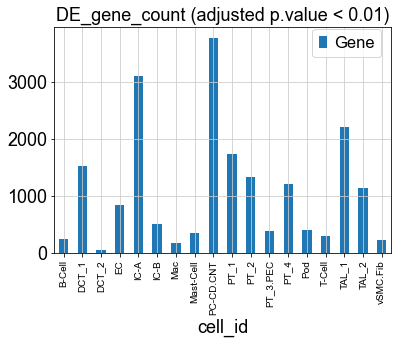

In [23]:
de_count_df = results_df[results_df["p_val_adj"]<0.01]\
[["Gene", "cell_id"]].groupby("cell_id")["Gene"].count().reset_index()

if 1:
    f = plt.figure(figsize = (3,2))
    ax = de_count_df.plot.bar(x='cell_id', y='Gene', rot=90)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    #ax.set_ylim(0,.4)
    ax.set_title('DE_gene_count (adjusted p.value < 0.01)')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, size=10)
    plt.legend(bbox_to_anchor=(0.97,0.99), loc='upper right', ncol=1, borderaxespad=0)
    plt.savefig('Kidney_human_de_count.pdf', bbox_inches='tight')

## ReactomePA comparison

In [24]:
results_df.head()

,Gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cell_id,file_id,comparison
0,LRP2,1.460593e-65,-2.349018,0.007,0.654,3.579037e-61,B-Cell,B-Cell,3xADPKD
1,SLC17A1,2.582939e-43,-1.741585,0.002,0.385,6.329233e-39,B-Cell,B-Cell,3xADPKD
2,RASSF4,3.071771e-35,-2.190378,0.004,0.346,7.527069e-31,B-Cell,B-Cell,3xADPKD
3,ANPEP,3.714276e-34,-1.768851,0.002,0.308,9.101461e-30,B-Cell,B-Cell,3xADPKD
4,SLC28A1,4.330618e-34,-1.885498,0.007,0.385,1.061175e-29,B-Cell,B-Cell,3xADPKD


In [25]:
de_pval_cutoff = 0.05

human_compare_df = results_df[(results_df["cell_id"].isin(["PT_4", "TAL_2"]))&\
           (results_df["p_val_adj"]<de_pval_cutoff) & (np.abs(results_df["avg_logFC"])> 0.0)]#.head()
print("All DE genes", human_compare_df.shape)

All DE genes (2713, 9)


In [26]:
results_df[(results_df["cell_id"].isin(["PT_4"]))&\
           (results_df["p_val_adj"]<de_pval_cutoff) & (results_df["avg_logFC"]> 0.0)].shape

(630, 9)

In [27]:
organoid_df.drop(["cluster_name"], axis=1, inplace=True)

In [28]:
organoid_df.head(2)

,Gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cell_id,comparison
0,RACK1,2.050826e-265,2.848747,0.961,0.0,4.564727e-261,PT_4,DiffExpr_2xPKD
1,ATP5IF1,1.773413e-246,2.263063,0.912,0.0,3.947262e-242,PT_4,DiffExpr_2xPKD


In [29]:
org_compare_df = organoid_df[organoid_df["p_val_adj"]<de_pval_cutoff]
print(org_compare_df.shape)

(12864, 8)


In [30]:
pd.merge(organoid_df, human_compare_df, left_on=["Gene", "cell_id"],\
        right_on=["Gene","cell_id"], suffixes=("_organoid", "_human"))

,Gene,p_val_organoid,avg_logFC_organoid,pct.1_organoid,pct.2_organoid,p_val_adj_organoid,cell_id,comparison_organoid,p_val_human,avg_logFC_human,pct.1_human,pct.2_human,p_val_adj_human,file_id,comparison_human
0,TCIM,3.280475e-155,1.161053,0.642,0.000,7.301681e-151,PT_4,DiffExpr_2xPKD,9.337923e-23,0.801059,0.116,0.010,2.288165e-18,PT_4,3xADPKD
1,SELENOS,3.559263e-125,0.823208,0.539,0.000,7.922208e-121,PT_4,DiffExpr_2xPKD,3.157187e-07,0.358312,0.045,0.008,7.736371e-03,PT_4,3xADPKD
2,FOS,5.149744e-120,1.656950,0.875,0.433,1.146230e-115,PT_4,DiffExpr_2xPKD,1.956197e-09,0.640742,0.183,0.083,4.793466e-05,PT_4,3xADPKD
3,MIA2,2.178799e-115,0.686807,0.520,0.008,4.849572e-111,PT_4,DiffExpr_2xPKD,9.299696e-23,-0.908848,0.073,0.311,2.278798e-18,PT_4,3xADPKD
4,PATJ,1.318286e-94,0.579685,0.425,0.000,2.934241e-90,PT_4,DiffExpr_2xPKD,3.842239e-21,-0.564862,0.418,0.674,9.415022e-17,PT_4,3xADPKD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,RNF130,9.714249e-01,0.030079,0.309,0.339,1.000000e+00,TAL_2,DiffExpr_2xPKD,1.363269e-08,-0.353122,0.152,0.299,3.340553e-04,TAL_2,3xADPKD
2432,NCKAP5,9.744209e-01,0.006438,0.028,0.028,1.000000e+00,TAL_2,DiffExpr_2xPKD,2.704440e-11,-0.400393,0.070,0.197,6.626961e-07,TAL_2,3xADPKD
2433,KNG1,9.789198e-01,-0.000260,0.001,0.001,1.000000e+00,TAL_2,DiffExpr_2xPKD,1.214534e-36,-0.660230,0.006,0.120,2.976094e-32,TAL_2,3xADPKD
2434,RASAL1,9.879645e-01,0.026909,0.167,0.176,1.000000e+00,TAL_2,DiffExpr_2xPKD,8.589514e-07,0.579195,0.203,0.073,2.104774e-02,TAL_2,3xADPKD


In [31]:
ho_compare_df = pd.merge(org_compare_df, human_compare_df, left_on=["Gene", "cell_id"],\
        right_on=["Gene","cell_id"], suffixes=("_organoid", "_human"))

In [32]:
Counter(ho_compare_df["cell_id"])

Counter({'PT_4': 329, 'TAL_2': 689})

In [33]:
## save data for computer-people up-regulated
#ho_compare_df.sort_values(by="avg_logFC_human", ascending=False).\
#to_csv(resulthome+"human_organoid_overlapping_de_genelist.txt")

In [34]:
## save data for non computer-people up-regulated
#ho_compare_df.sort_values(by="avg_logFC_human", ascending=False).\
#to_excel(resulthome+"human_organoid_overlapping_de_genelist.xlsx")

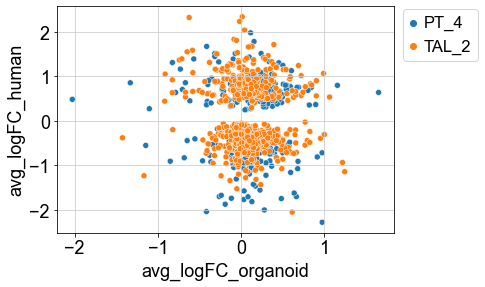

In [35]:
f = plt.figure(figsize = (6, 4))

ax = sns.scatterplot(data=ho_compare_df, x="avg_logFC_organoid", y="avg_logFC_human",hue="cell_id")
plt.legend(bbox_to_anchor=(1.25, 0.99), loc='upper right', ncol=1, borderaxespad=0)

#plt.savefig('human_organoid_common_de_genes.pdf', bbox_inches='tight')

In [36]:
## Save common DE gene list - down-regulated

#ho_compare_df[(ho_compare_df["avg_logFC_organoid"] < 0)\
#                         &((ho_compare_df["avg_logFC_human"] < 0))].sort_values(by="avg_logFC_human").\
#to_excel(resulthome+"human_organoid_common_downregulated_genes.xlsx")

In [37]:
cols = ho_compare_df.columns.values.tolist()
print(cols)

['Gene', 'p_val_organoid', 'avg_logFC_organoid', 'pct.1_organoid', 'pct.2_organoid', 'p_val_adj_organoid', 'cell_id', 'comparison_organoid', 'p_val_human', 'avg_logFC_human', 'pct.1_human', 'pct.2_human', 'p_val_adj_human', 'file_id', 'comparison_human']


In [38]:
## both up

## part of it goes to main, supplemanrtary and list goes to supple.

genelist = ho_compare_df[(ho_compare_df["cell_id"]=="PT_4")& (ho_compare_df["avg_logFC_organoid"] > 0)\
                         &((ho_compare_df["avg_logFC_human"]>0))]["Gene"].values.tolist()

pd.DataFrame(genelist, columns=["#gene"]).to_csv(resulthome+"pt4_both_up.genelist.ora", index=False)
print(len(genelist))

genelist = ho_compare_df[(ho_compare_df["cell_id"]=="TAL_2")& (ho_compare_df["avg_logFC_organoid"] > 0)\
                         &((ho_compare_df["avg_logFC_human"] > 0))]["Gene"].values.tolist()

pd.DataFrame(genelist, columns=["#gene"]).to_csv(resulthome+"tal2_both_up.genelist.ora",index=False)
print(len(genelist))



## both down

genelist = ho_compare_df[(ho_compare_df["cell_id"]=="PT_4")& (ho_compare_df["avg_logFC_organoid"] < 0)\
                         &((ho_compare_df["avg_logFC_human"] < 0))]["Gene"].values.tolist()

#pd.DataFrame(genelist, columns=["#gene"]).to_csv(resulthome+"pt4_both_down.genelist.ora", index=False)
print(len(genelist))

genelist = ho_compare_df[(ho_compare_df["cell_id"]=="TAL_2")& (ho_compare_df["avg_logFC_organoid"] < 0)\
                         &((ho_compare_df["avg_logFC_human"] < 0))]["Gene"].values.tolist()

#pd.DataFrame(genelist, columns=["#gene"]).to_csv(resulthome+"tal2_both_down.genelist.ora",index=False)
print(len(genelist))

124
133
32
159


In [39]:
cluster_id = "PT_4"

o1 = ho_compare_df[(ho_compare_df["cell_id"]==cluster_id)& (ho_compare_df["avg_logFC_organoid"] < 0)]\
                         ["Gene"].values.tolist()

o2 = ho_compare_df[(ho_compare_df["cell_id"]==cluster_id)& (ho_compare_df["avg_logFC_human"] < 0)]\
                         ["Gene"].values.tolist()

In [40]:
len(set(o1)), len(set(o2)), len(set(o1).intersection(o2))

(78, 159, 32)

In [41]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

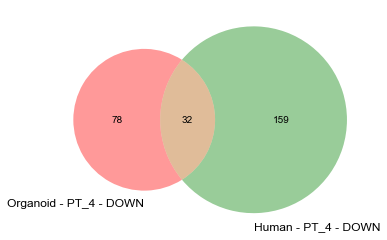

In [42]:
dp = venn2(subsets = (78, 159, 32), set_labels = ('Organoid - PT_4 - DOWN', 'Human - PT_4 - DOWN'))

#matplotlib.pyplot.savefig('PT4_DE_down_genes_overlap.pdf', bbox_inches='tight')

In [43]:
resulthome

'/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/'

In [47]:
%load_ext rpy2.ipython

In [48]:
%%R

library("ReactomePA")
library("fgsea")
library("tidyverse")
library("clusterProfiler")

2022-04-13 14:00:49,554 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 

2022-04-13 14:00:52,156 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: ReactomePA v1.36.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/reactomepa.html

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479

2022-04-13 14:00:52,716 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: ── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

2022-04-13 14:00:52,737 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequir

In [49]:
#%%R
#sessionInfo()

In [54]:
%%R
##library(multienrichjam)
##library(msigdbr)

## reactomePA

## we have one file per cluster.
## each file looks like:
    ## #gene
    ## gene1
    ## gene2 
    ## gene3

path <- "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/"
setwd(path)

myfiles <- list.files(path, pattern="*both_up.genelist.ora")

# for each cluster 
for (rnk.file in myfiles){
    #step1: read the genefile
    print(rnk.file)
    out.file  <- paste0(strsplit(rnk.file, ".rnk"), "_", "reactomepa.ora")

    ranks <- read.table(rnk.file, header=FALSE, colClasses = c("character"))
    ranks <- deframe(ranks)  # needs tidyverse
    #print(head(ranks, 20))
    
    #step2: convert to gene_id
    eg   <- bitr(ranks, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
    ## get list of gene_ids
    ranks<- deframe(eg["ENTREZID"])
    
    ## step3: use these gene_ids to do enrichment analyses function
    x <- enrichPathway(gene=ranks, pvalueCutoff = 0.05, readable=TRUE)
    print(head(x))
    
    ## step4: save the files as csv
    fgseaResTidy <- x %>%
      as_tibble() %>%
      #arrange(desc(p.adjust)) %>%
      arrange(p.adjust) %>% 
      as.data.frame() 
    
    write.table(fgseaResTidy, paste0(out.file, ".fgseaResTidy.csv" ), sep="\t", quote = FALSE)
    }

[1] "pt4_both_up.genelist.ora"
 [1] "TCIM"       "SELENOS"    "FOS"        "CFTR"       "AC007906.2"
 [6] "CCDC198"    "AC019197.1" "RHEX"       "KLF5"       "H3F3B"     
[11] "HDGFL3"     "CLDN4"      "DUSP1"      "GABRP"      "PDK4"      
[16] "AC020916.1" "RHOU"       "ATF3"       "CRIP2"      "NFKBIZ"    


2022-04-13 14:02:30,858 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: Loading required package: org.Hs.eg.db

2022-04-13 14:02:30,865 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: Loading required package: AnnotationDbi

2022-04-13 14:02:30,869 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: Loading required package: stats4

2022-04-13 14:02:30,882 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: Loading required package: BiocGenerics

2022-04-13 14:02:30,888 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: Loading required package: parallel

2022-04-13 14:02:30,917 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 
Attaching package: ‘BiocGenerics’


2022-04-13 14:02:30,919 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequ

                         ID                                  Description
R-HSA-421270   R-HSA-421270              Cell-cell junction organization
R-HSA-1500931 R-HSA-1500931                      Cell-Cell communication
R-HSA-446728   R-HSA-446728                   Cell junction organization
R-HSA-420029   R-HSA-420029                  Tight junction interactions
R-HSA-8876384 R-HSA-8876384 Listeria monocytogenes entry into host cells
              GeneRatio   BgRatio       pvalue    p.adjust      qvalue
R-HSA-421270       6/75  64/10856 4.844648e-06 0.002015373 0.001963357
R-HSA-1500931      7/75 129/10856 2.883247e-05 0.004553511 0.004435986
R-HSA-446728       6/75  91/10856 3.717727e-05 0.004553511 0.004435986
R-HSA-420029       4/75  29/10856 4.378376e-05 0.004553511 0.004435986
R-HSA-8876384      3/75  20/10856 3.318044e-04 0.027606130 0.026893623
                                                   geneID Count
R-HSA-421270          CLDN4/CLDN3/CDH1/CLDN1/CTNNB1/PRKCI     6
R-HSA-15

2022-04-13 14:02:40,529 [40664] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                Description GeneRatio   BgRatio
R-HSA-9012999 R-HSA-9012999           RHO GTPase cycle     13/69 443/10856
R-HSA-9013026 R-HSA-9013026          RHOB GTPase cycle      5/69  70/10856
R-HSA-446728   R-HSA-446728 Cell junction organization      5/69  91/10856
R-HSA-8980692 R-HSA-8980692          RHOA GTPase cycle      6/69 147/10856
                    pvalue   p.adjust      qvalue
R-HSA-9012999 3.494803e-06 0.00124415 0.001151445
R-HSA-9013026 7.871178e-05 0.01401070 0.012966730
R-HSA-446728  2.728589e-04 0.02943379 0.027240617
R-HSA-8980692 3.307168e-04 0.02943379 0.027240617
                                                                                        geneID
R-HSA-9012999 RHOU/CAVIN1/PRAG1/PCDH7/AKAP13/DSP/ARHGAP26/MYO9A/FNBP1/MYO6/SH3RF1/ARAP2/DIAPH2
R-HSA-9013026                                               CAVIN1/PCDH7/AKAP13/ARHGAP26/MYO9A
R-HSA-446728                                                    AFDN/LAMB3/PARD6B/CTNNA1/P

## Plot ORA comparison

In [44]:
os.system("ls " + resulthome + "*both_up.genelist.ora_reactomepa.ora.fgseaResTidy.csv > "\
         + resulthome+"tmp.txt")

0

In [45]:
files = pd.read_table(resulthome+'tmp.txt', header=None)[0].values.tolist()

frames = []
for filename in files:
    file_id = filename.split("/")[-1].split(".genelist")[0]
    tmp     = pd.read_table(filename)
    tmp["file_id"] = file_id
    frames.append(tmp)

In [46]:
plot1_df = pd.concat(frames)

In [47]:
plot1_df.head(2)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,file_id
1,R-HSA-421270,Cell-cell junction organization,6/75,64/10856,0.000005,0.002015,0.001963,CLDN4/CLDN3/CDH1/CLDN1/CTNNB1/PRKCI,6,pt4_both_up
2,R-HSA-1500931,Cell-Cell communication,7/75,129/10856,0.000029,0.004554,0.004436,CLDN4/CLDN3/CDH1/KIRREL1/CLDN1/CTNNB1/PRKCI,7,pt4_both_up


In [48]:
plot1_df["neglog10"] = -1.0*np.log10(plot1_df["p.adjust"])
plot1_df.sort_values(by="neglog10", ascending=False, inplace=True)

In [49]:
plot_df = plot1_df[["file_id", "Description", "neglog10"]]\
    .pivot(index='file_id', columns='Description', values='neglog10').fillna(0)

In [50]:
plot_df

Description,Cell junction organization,Cell-Cell communication,Cell-cell junction organization,Listeria monocytogenes entry into host cells,RHO GTPase cycle,RHOA GTPase cycle,RHOB GTPase cycle,Tight junction interactions
file_id,,,,,,,,
pt4_both_up,2.341654,2.341654,2.695644,1.558994,0.000000,0.000000,0.00000,2.341654
tal2_both_up,1.531154,0.000000,0.000000,0.000000,2.905127,1.531154,1.85354,0.000000


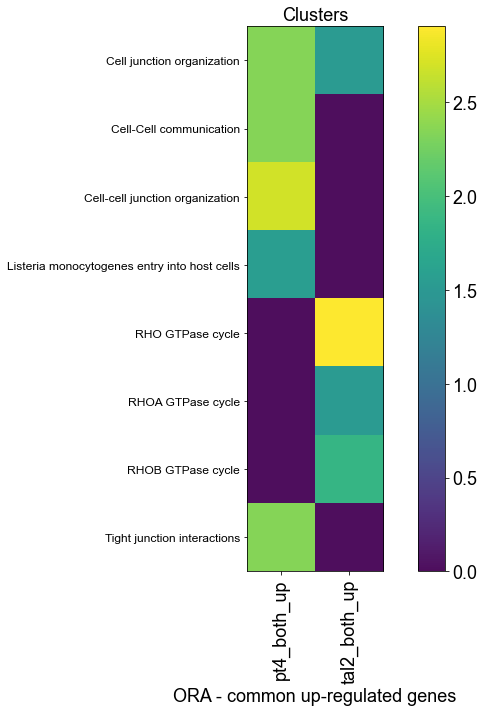

In [51]:
## Plot scores

mat = plot_df.to_numpy()

#print(mat)
plt.figure(figsize=(10, 10))

plt.imshow(np.transpose(mat),cmap=plt.cm.get_cmap('viridis'), \
          alpha=0.95)#,interpolation='none', aspect='auto')

plt.yticks(ticks=range(mat.shape[1]), labels=[s[0:] for s in plot_df.columns], rotation=0,fontsize=12)
plt.xticks(ticks=range(mat.shape[0]), labels=[s[0:] for s in plot_df.index], rotation=90)
plt.xlabel('ORA - common up-regulated genes')

plt.grid(None)   #<---- this should remove that white grid
#plt.grid(color='w', linewidth=2)
#plt.grid(which='minor', color='w', linestyle='-', linewidth=12)

plt.colorbar()
plt.title('Clusters')

#plt.show()
plt.tight_layout()

#plt.savefig(resulthome+"pt_up_ora.pdf")

## human only

In [64]:
#Counter(df[(df["p_val_adj"]<0.01) & (df["avg_logFC"]>0) & (df["pvals_adj"]<0.01) &\
#   (df["logfoldchanges"]>specificity_cutoff) ]["cell_id"])

In [52]:
mygrps = results_df.groupby("cell_id")

In [53]:
tmp_frames = []
gene_frames= []

expr_cutoff = 1

for name, mygrp in mygrps:
    
    #print(mygrp[(mygrp["p_val_adj"]<0.01) &(mygrp["avg_logFC"]>0)]\
    #      .sort_values(by="avg_logFC", ascending=False).head(5))
    
    ## just plot top DE genes later
    tmp_frames.append(mygrp[(mygrp["p_val_adj"]<0.01) &(mygrp["avg_logFC"]>0)]\
          .sort_values(by="avg_logFC", ascending=False).head(5))
    
    genelist = mygrp[(mygrp["p_val_adj"]<0.01) &(mygrp["avg_logFC"]>expr_cutoff)]["Gene"].values.tolist()
    
    if len(genelist) ==0: continue
    pd.DataFrame(genelist, columns=["#gene"]).to_csv(resulthome+name+"_up.human.genelist.ora", index=False)

    print(name, mygrp[(mygrp["p_val_adj"]<0.01) &(mygrp["avg_logFC"]>expr_cutoff)].shape, len(genelist))

B-Cell (4, 9) 4
DCT_1 (58, 9) 58
DCT_2 (8, 9) 8
EC (40, 9) 40
IC-A (12, 9) 12
IC-B (21, 9) 21
PC-CD.CNT (39, 9) 39
PT_1 (42, 9) 42
PT_2 (72, 9) 72
PT_3.PEC (55, 9) 55
PT_4 (90, 9) 90
Pod (8, 9) 8
T-Cell (5, 9) 5
TAL_1 (58, 9) 58
TAL_2 (107, 9) 107
vSMC.Fib (58, 9) 58


In [98]:
%%R
library("ReactomePA")
library("fgsea")
library("tidyverse")
library("clusterProfiler")
##library(multienrichjam)
##library(msigdbr)

## reactomePA

## we have one file per cluster.
## each file looks like:
    ## #gene
    ## gene1
    ## gene2 
    ## gene3

path <- "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/"
setwd(path)

myfiles <- list.files(path, pattern="*_up.human.genelist.ora")

# for each cluster 
for (rnk.file in myfiles){
    #step1: read the genefile
    print(rnk.file)
    out.file  <- paste0(strsplit(rnk.file, ".rnk"), "_", "reactomepa.ora")

    ranks <- read.table(rnk.file, header=FALSE, colClasses = c("character"))
    ranks <- deframe(ranks)  # needs tidyverse
    print(head(ranks, 20))
    
    #step2: convert to gene_id
    eg   <- bitr(ranks, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
    ## get list of gene_ids
    ranks<- deframe(eg["ENTREZID"])
    
    ## step3: use these gene_ids to do enrichment analyses function
    x <- enrichPathway(gene=ranks, pvalueCutoff = 0.05, readable=TRUE)
    print(head(x))
    
    ## step4: save the files as csv
    fgseaResTidy <- x %>%
      as_tibble() %>%
      #arrange(desc(p.adjust)) %>%
      arrange(p.adjust) %>% 
      as.data.frame() 
    
    write.table(fgseaResTidy, paste0(out.file, ".fgseaResTidy.csv" ), sep="\t", quote = FALSE)
    }

[1] "B-Cell_up.human.genelist.ora"
[1] "ARHGAP15" "MT1X"     "ZHX2"     "REL"     


2022-04-08 16:24:29,029 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID
R-HSA-5661231 R-HSA-5661231
R-HSA-5660526 R-HSA-5660526
R-HSA-1169091 R-HSA-1169091
R-HSA-1168372 R-HSA-1168372
R-HSA-9013423 R-HSA-9013423
R-HSA-983705   R-HSA-983705
                                                       Description GeneRatio
R-HSA-5661231                         Metallothioneins bind metals       1/3
R-HSA-5660526                               Response to metal ions       1/3
R-HSA-1169091                   Activation of NF-kappaB in B cells       1/3
R-HSA-1168372 Downstream signaling events of B Cell Receptor (BCR)       1/3
R-HSA-9013423                                    RAC3 GTPase cycle       1/3
R-HSA-983705                Signaling by the B Cell Receptor (BCR)       1/3
                BgRatio      pvalue   p.adjust      qvalue   geneID Count
R-HSA-5661231  11/10856 0.003036994 0.01545679 0.004067575     MT1X     1
R-HSA-5660526  14/10856 0.003864197 0.01545679 0.004067575     MT1X     1
R-HSA-1169091  67/10856 0.018402757 0.04084

2022-04-08 16:24:35,542 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                                    Description
R-HSA-373760   R-HSA-373760                             L1CAM interactions
R-HSA-445095   R-HSA-445095            Interaction between L1 and Ankyrins
R-HSA-6794362 R-HSA-6794362       Protein-protein interactions at synapses
R-HSA-6802948 R-HSA-6802948 Signaling by high-kinase activity BRAF mutants
R-HSA-445355   R-HSA-445355                      Smooth Muscle Contraction
R-HSA-5674135 R-HSA-5674135                      MAP2K and MAPK activation
              GeneRatio   BgRatio       pvalue    p.adjust      qvalue
R-HSA-373760       5/36 119/10856 4.179117e-05 0.009334236 0.006842057
R-HSA-445095       3/36  31/10856 1.412397e-04 0.009334236 0.006842057
R-HSA-6794362      4/36  86/10856 1.782216e-04 0.009334236 0.006842057
R-HSA-6802948      3/36  36/10856 2.218093e-04 0.009334236 0.006842057
R-HSA-445355       3/36  40/10856 3.041469e-04 0.009334236 0.006842057
R-HSA-5674135      3/36  40/10856 3.041469e-04 0.

2022-04-08 16:24:42,027 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                       Description GeneRatio
R-HSA-3781865 R-HSA-3781865         Diseases of glycosylation       2/4
R-HSA-5668914 R-HSA-5668914            Diseases of metabolism       2/4
R-HSA-2022923 R-HSA-2022923     Dermatan sulfate biosynthesis       1/4
R-HSA-2024101 R-HSA-2024101                 CS/DS degradation       1/4
R-HSA-159418   R-HSA-159418 Recycling of bile acids and salts       1/4
R-HSA-416700   R-HSA-416700     Other semaphorin interactions       1/4
                BgRatio      pvalue   p.adjust      qvalue      geneID Count
R-HSA-3781865 143/10856 0.001016073 0.02351958 0.005415694 VCAN/SEMA5A     2
R-HSA-5668914 245/10856 0.002953641 0.02351958 0.005415694 VCAN/SEMA5A     2
R-HSA-2022923  11/10856 0.004047461 0.02351958 0.005415694        VCAN     1
R-HSA-2024101  14/10856 0.005149178 0.02351958 0.005415694        VCAN     1
R-HSA-159418   16/10856 0.005883148 0.02351958 0.005415694       ABCC3     1
R-HSA-416700   19/10856 0.00698334

2022-04-08 16:24:48,281 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID
R-HSA-6802952 R-HSA-6802952
R-HSA-354194   R-HSA-354194
R-HSA-372708   R-HSA-372708
R-HSA-1474244 R-HSA-1474244
R-HSA-6802957 R-HSA-6802957
R-HSA-216083   R-HSA-216083
                                                             Description
R-HSA-6802952                          Signaling by BRAF and RAF fusions
R-HSA-354194  GRB2:SOS provides linkage to MAPK signaling for Integrins 
R-HSA-372708             p130Cas linkage to MAPK signaling for integrins
R-HSA-1474244                          Extracellular matrix organization
R-HSA-6802957                                   Oncogenic MAPK signaling
R-HSA-216083                          Integrin cell surface interactions
              GeneRatio   BgRatio       pvalue   p.adjust     qvalue
R-HSA-6802952      3/25  67/10856 0.0004689430 0.01814000 0.01151300
R-HSA-354194       2/25  15/10856 0.0005248856 0.01814000 0.01151300
R-HSA-372708       2/25  15/10856 0.0005248856 0.01814000 0.01151300
R-HSA-1474244    

2022-04-08 16:24:54,522 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                                        Description
R-HSA-445095   R-HSA-445095                Interaction between L1 and Ankyrins
R-HSA-6802948 R-HSA-6802948     Signaling by high-kinase activity BRAF mutants
R-HSA-5674135 R-HSA-5674135                          MAP2K and MAPK activation
R-HSA-9656223 R-HSA-9656223                          Signaling by RAF1 mutants
R-HSA-6802946 R-HSA-6802946 Signaling by moderate kinase activity BRAF mutants
R-HSA-6802949 R-HSA-6802949                           Signaling by RAS mutants
              GeneRatio  BgRatio       pvalue    p.adjust      qvalue
R-HSA-445095        2/9 31/10856 0.0002805876 0.007085546 0.002458836
R-HSA-6802948       2/9 36/10856 0.0003793340 0.007085546 0.002458836
R-HSA-5674135       2/9 40/10856 0.0004688440 0.007085546 0.002458836
R-HSA-9656223       2/9 43/10856 0.0005420769 0.007085546 0.002458836
R-HSA-6802946       2/9 47/10856 0.0006478155 0.007085546 0.002458836
R-HSA-6802949       2/9 47/

2022-04-08 16:25:00,613 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



[1] ID          Description GeneRatio   BgRatio     pvalue      p.adjust   
[7] qvalue      geneID      Count      
<0 rows> (or 0-length row.names)
[1] "PC-CD.CNT_up.human.genelist.ora"
 [1] "XIST"    "VCL"     "RUNX1"   "GLS"     "ACTG1"   "MSC-AS1" "SCIN"   
 [8] "SGCD"    "SCN3A"   "MACC1"   "LTBP1"   "TPM4"    "FERMT2"  "KRT19"  
[15] "NR4A1"   "RCAN1"   "SNX2"    "VMP1"    "TUFT1"   "RBBP8"  


2022-04-08 16:25:06,425 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                                    Description
R-HSA-446353   R-HSA-446353         Cell-extracellular matrix interactions
R-HSA-8874081 R-HSA-8874081                   MET activates PTK2 signaling
R-HSA-445095   R-HSA-445095            Interaction between L1 and Ankyrins
R-HSA-373760   R-HSA-373760                             L1CAM interactions
R-HSA-6802948 R-HSA-6802948 Signaling by high-kinase activity BRAF mutants
R-HSA-2129379 R-HSA-2129379       Molecules associated with elastic fibres
              GeneRatio   BgRatio       pvalue   p.adjust     qvalue
R-HSA-446353       2/23  18/10856 0.0006435466 0.04964347 0.03534984
R-HSA-8874081      2/23  30/10856 0.0018016270 0.04964347 0.03534984
R-HSA-445095       2/23  31/10856 0.0019233995 0.04964347 0.03534984
R-HSA-373760       3/23 119/10856 0.0019379840 0.04964347 0.03534984
R-HSA-6802948      2/23  36/10856 0.0025891819 0.04964347 0.03534984
R-HSA-2129379      2/23  38/10856 0.0028817739 0.04964347 0.0

2022-04-08 16:25:12,113 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                                   Description
R-HSA-5674400 R-HSA-5674400 Constitutive Signaling by AKT1 E17K in Cancer
R-HSA-383280   R-HSA-383280        Nuclear Receptor transcription pathway
R-HSA-5578775 R-HSA-5578775                               Ion homeostasis
R-HSA-2219528 R-HSA-2219528                  PI3K/AKT Signaling in Cancer
R-HSA-2672351 R-HSA-2672351                      Stimuli-sensing channels
R-HSA-5576891 R-HSA-5576891                            Cardiac conduction
              GeneRatio   BgRatio      pvalue   p.adjust      qvalue geneID
R-HSA-5674400       1/2  25/10856 0.004600656 0.03773271 0.007221571  NR4A1
R-HSA-383280        1/2  52/10856 0.009557451 0.03773271 0.007221571  NR4A1
R-HSA-5578775       1/2  56/10856 0.010290739 0.03773271 0.007221571   RYR2
R-HSA-2219528       1/2 104/10856 0.019069010 0.04331349 0.008289663  NR4A1
R-HSA-2672351       1/2 109/10856 0.019981165 0.04331349 0.008289663   RYR2
R-HSA-5576891       1/2 12

2022-04-08 16:25:17,715 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



[1] ID          Description GeneRatio   BgRatio     pvalue      p.adjust   
[7] qvalue      geneID      Count      
<0 rows> (or 0-length row.names)
[1] "PT_2_up.human.genelist.ora"
 [1] "RFX2"   "TGFBR2" "SGMS2"  "CAMK1D" "FOXP2"  "MET"    "NR4A1"  "SYNE1" 
 [9] "PRKX"   "EMP1"   "EDIL3"  "MACC1"  "RP1"    "LAMA3"  "EZR"    "MYO10" 
[17] "NEDD9"  "P3H2"   "SIK2"   "PFKP"  


2022-04-08 16:25:23,426 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID
R-HSA-2219528 R-HSA-2219528
R-HSA-5663202 R-HSA-5663202
R-HSA-8874081 R-HSA-8874081
R-HSA-2219530 R-HSA-2219530
R-HSA-445355   R-HSA-445355
R-HSA-8875878 R-HSA-8875878
                                                                                   Description
R-HSA-2219528                                                     PI3K/AKT Signaling in Cancer
R-HSA-5663202 Diseases of signal transduction by growth factor receptors and second messengers
R-HSA-8874081                                                     MET activates PTK2 signaling
R-HSA-2219530                                Constitutive Signaling by Aberrant PI3K in Cancer
R-HSA-445355                                                         Smooth Muscle Contraction
R-HSA-8875878                                                       MET promotes cell motility
              GeneRatio   BgRatio       pvalue   p.adjust     qvalue
R-HSA-2219528      5/45 104/10856 6.601212e-05 0.01821935 0.01459215
R

2022-04-08 16:25:29,217 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                                 Description
R-HSA-5661231 R-HSA-5661231                Metallothioneins bind metals
R-HSA-5660526 R-HSA-5660526                      Response to metal ions
R-HSA-3000171 R-HSA-3000171      Non-integrin membrane-ECM interactions
R-HSA-1650814 R-HSA-1650814 Collagen biosynthesis and modifying enzymes
R-HSA-1474244 R-HSA-1474244           Extracellular matrix organization
R-HSA-1474290 R-HSA-1474290                          Collagen formation
              GeneRatio   BgRatio       pvalue     p.adjust       qvalue
R-HSA-5661231      4/37  11/10856 3.704433e-08 6.149359e-06 4.757272e-06
R-HSA-5660526      4/37  14/10856 1.115499e-07 9.258640e-06 7.162676e-06
R-HSA-3000171      5/37  59/10856 1.522033e-06 8.421913e-05 6.515367e-05
R-HSA-1650814      5/37  67/10856 2.878847e-06 1.194722e-04 9.242615e-05
R-HSA-1474244      8/37 301/10856 6.098106e-06 2.024571e-04 1.566250e-04
R-HSA-1474290      5/37  90/10856 1.237967e-05 3.425041e-0

2022-04-08 16:25:35,786 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID
R-HSA-445355   R-HSA-445355
R-HSA-5663202 R-HSA-5663202
R-HSA-2219528 R-HSA-2219528
R-HSA-8874081 R-HSA-8874081
R-HSA-2219530 R-HSA-2219530
                                                                                   Description
R-HSA-445355                                                         Smooth Muscle Contraction
R-HSA-5663202 Diseases of signal transduction by growth factor receptors and second messengers
R-HSA-2219528                                                     PI3K/AKT Signaling in Cancer
R-HSA-8874081                                                     MET activates PTK2 signaling
R-HSA-2219530                                Constitutive Signaling by Aberrant PI3K in Cancer
              GeneRatio   BgRatio       pvalue   p.adjust     qvalue
R-HSA-445355       4/56  40/10856 5.055001e-05 0.01597380 0.01388795
R-HSA-5663202      9/56 395/10856 1.695344e-04 0.02000011 0.01738850
R-HSA-2219528      5/56 104/10856 1.898745e-04 0.020000

2022-04-08 16:25:41,691 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                  Description GeneRatio  BgRatio
R-HSA-5661231 R-HSA-5661231 Metallothioneins bind metals       2/5 11/10856
R-HSA-5660526 R-HSA-5660526       Response to metal ions       2/5 14/10856
R-HSA-9020958 R-HSA-9020958     Interleukin-21 signaling       1/5 10/10856
R-HSA-2029481 R-HSA-2029481              FCGR activation       1/5 12/10856
R-HSA-210990   R-HSA-210990          PECAM1 interactions       1/5 12/10856
R-HSA-389359   R-HSA-389359  CD28 dependent Vav1 pathway       1/5 12/10856
                    pvalue     p.adjust       qvalue    geneID Count
R-HSA-5661231 9.319071e-06 0.0006472326 0.0001703244 MT2A/MT1X     2
R-HSA-5660526 1.541030e-05 0.0006472326 0.0001703244 MT2A/MT1X     2
R-HSA-9020958 4.598116e-03 0.0370361235 0.0097463483     STAT4     1
R-HSA-2029481 5.515706e-03 0.0370361235 0.0097463483       FYN     1
R-HSA-210990  5.515706e-03 0.0370361235 0.0097463483       FYN     1
R-HSA-389359  5.515706e-03 0.0370361235 0.0097463483  

2022-04-08 16:25:47,390 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID
R-HSA-446107   R-HSA-446107
R-HSA-8874081 R-HSA-8874081
R-HSA-445355   R-HSA-445355
R-HSA-8875878 R-HSA-8875878
R-HSA-2022090 R-HSA-2022090
R-HSA-2214320 R-HSA-2214320
                                                               Description
R-HSA-446107                                 Type I hemidesmosome assembly
R-HSA-8874081                                 MET activates PTK2 signaling
R-HSA-445355                                     Smooth Muscle Contraction
R-HSA-8875878                                   MET promotes cell motility
R-HSA-2022090 Assembly of collagen fibrils and other multimeric structures
R-HSA-2214320                                   Anchoring fibril formation
              GeneRatio  BgRatio       pvalue     p.adjust       qvalue
R-HSA-446107       3/35 11/10856 4.976979e-06 0.0009506029 0.0008277501
R-HSA-8874081      3/35 30/10856 1.174258e-04 0.0112141679 0.0097648858
R-HSA-445355       3/35 40/10856 2.795137e-04 0.0143687175 0.01

2022-04-08 16:25:53,156 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                    Description GeneRatio  BgRatio
R-HSA-446107   R-HSA-446107  Type I hemidesmosome assembly      3/74 11/10856
R-HSA-8847993 R-HSA-8847993 ERBB2 Activates PTK6 Signaling      3/74 13/10856
R-HSA-6785631 R-HSA-6785631  ERBB2 Regulates Cell Motility      3/74 15/10856
R-HSA-1963640 R-HSA-1963640 GRB2 events in ERBB2 signaling      3/74 16/10856
R-HSA-1963642 R-HSA-1963642 PI3K events in ERBB2 signaling      3/74 16/10856
R-HSA-1250196 R-HSA-1250196 SHC1 events in ERBB2 signaling      3/74 22/10856
                    pvalue   p.adjust     qvalue           geneID Count
R-HSA-446107  4.824009e-05 0.01233322 0.01045986 LAMA3/LAMC2/PLEC     3
R-HSA-8847993 8.279943e-05 0.01233322 0.01045986   NRG3/EGFR/EREG     3
R-HSA-6785631 1.304404e-04 0.01233322 0.01045986   NRG3/EGFR/EREG     3
R-HSA-1963640 1.597567e-04 0.01233322 0.01045986   NRG3/EGFR/EREG     3
R-HSA-1963642 1.597567e-04 0.01233322 0.01045986   NRG3/EGFR/EREG     3
R-HSA-1250196 4.266058

2022-04-08 16:25:59,116 [1159] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 'select()' returned 1:1 mapping between keys and columns



                         ID                               Description GeneRatio
R-HSA-400253   R-HSA-400253                           Circadian Clock      4/44
R-HSA-1474244 R-HSA-1474244         Extracellular matrix organization      7/44
R-HSA-445355   R-HSA-445355                 Smooth Muscle Contraction      3/44
R-HSA-2025928 R-HSA-2025928                Calcineurin activates NFAT      2/44
R-HSA-5661231 R-HSA-5661231              Metallothioneins bind metals      2/44
R-HSA-5607763 R-HSA-5607763 CLEC7A (Dectin-1) induces NFAT activation      2/44
                BgRatio       pvalue   p.adjust     qvalue
R-HSA-400253   70/10856 0.0001771426 0.02872237 0.02434432
R-HSA-1474244 301/10856 0.0001865089 0.02872237 0.02434432
R-HSA-445355   40/10856 0.0005527667 0.04847619 0.04108713
R-HSA-2025928  11/10856 0.0008627765 0.04847619 0.04108713
R-HSA-5661231  11/10856 0.0008627765 0.04847619 0.04108713
R-HSA-5607763  13/10856 0.0012172845 0.04847619 0.04108713
                           

In [99]:
os.system("ls " + resulthome + "*.human.genelist.ora_reactomepa.ora.fgseaResTidy.csv > "\
         + resulthome+"tmp.txt")

0

In [100]:
files = pd.read_table(resulthome+'tmp.txt', header=None)[0].values.tolist()

frames = []
for filename in files:
    file_id = filename.split("/")[-1].split(".genelist")[0]
    tmp = pd.read_table(filename)
    tmp["file_id"] = file_id
    frames.append(tmp)
    print(file_id, tmp.shape)

B-Cell_up.human (6, 10)
DCT_1_up.human (39, 10)
DCT_2_up.human (20, 10)
EC_up.human (22, 10)
IC-A_up.human (27, 10)
IC-B_up.human (0, 10)
PC-CD.CNT_up.human (15, 10)
PT_1_up.human (0, 10)
PT_2_up.human (27, 10)
PT_3.PEC_up.human (14, 10)
PT_4_up.human (5, 10)
Pod_up.human (8, 10)
T-Cell_up.human (55, 10)
TAL_1_up.human (6, 10)
TAL_2_up.human (32, 10)
vSMC.Fib_up.human (9, 10)


In [101]:
plot1_df = pd.concat(frames)

In [102]:
plot1_df.head()

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,file_id
1,R-HSA-5661231,Metallothioneins bind metals,1/3,11/10856,0.003037,0.015457,0.004068,MT1X,1,B-Cell_up.human
2,R-HSA-5660526,Response to metal ions,1/3,14/10856,0.003864,0.015457,0.004068,MT1X,1,B-Cell_up.human
3,R-HSA-1169091,Activation of NF-kappaB in B cells,1/3,67/10856,0.018403,0.040847,0.010749,REL,1,B-Cell_up.human
4,R-HSA-1168372,Downstream signaling events of B Cell Receptor...,1/3,83/10856,0.022764,0.040847,0.010749,REL,1,B-Cell_up.human
5,R-HSA-9013423,RAC3 GTPase cycle,1/3,94/10856,0.025754,0.040847,0.010749,ARHGAP15,1,B-Cell_up.human


In [103]:
plot1_df["neglog10"] = -1.0*np.log10(plot1_df["p.adjust"])
plot1_df.sort_values(by="neglog10", ascending=False, inplace=True)

In [104]:
mygrps = plot1_df.groupby("file_id")

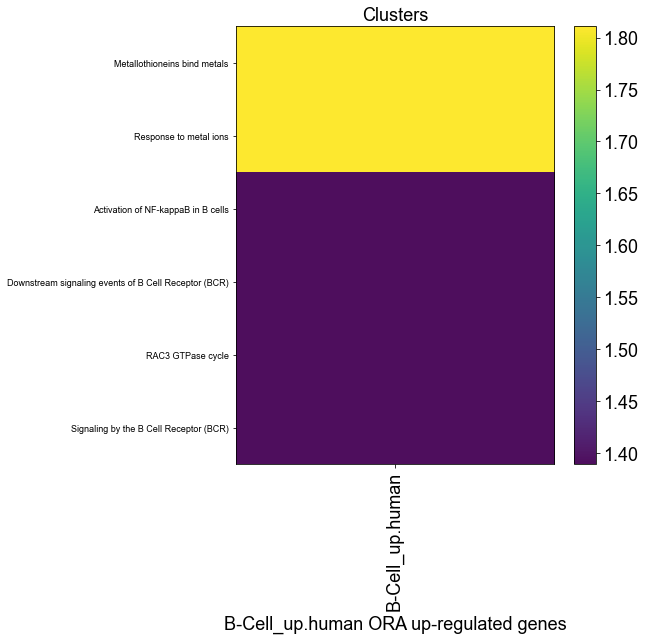

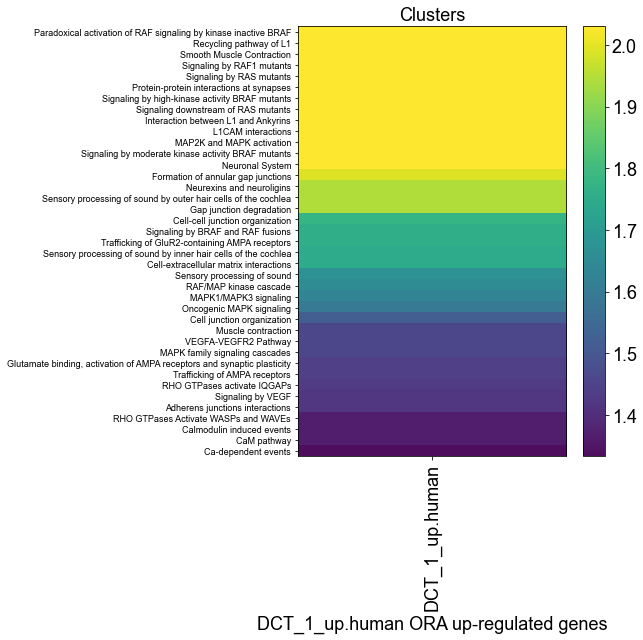

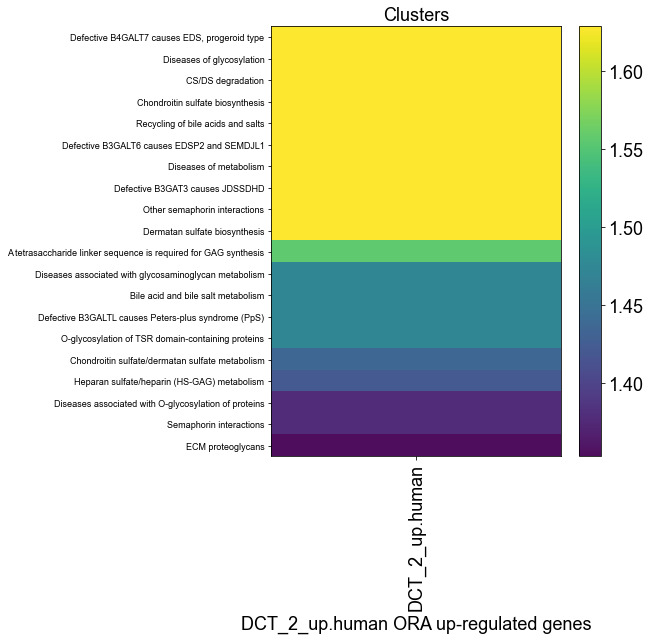

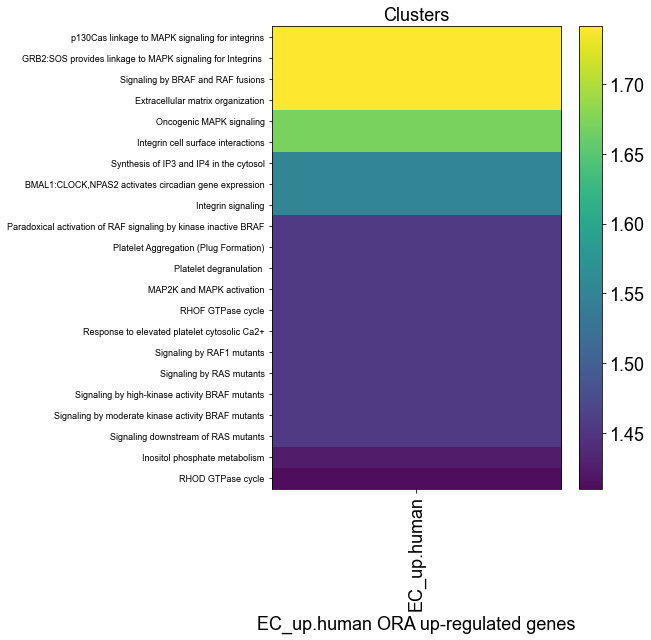

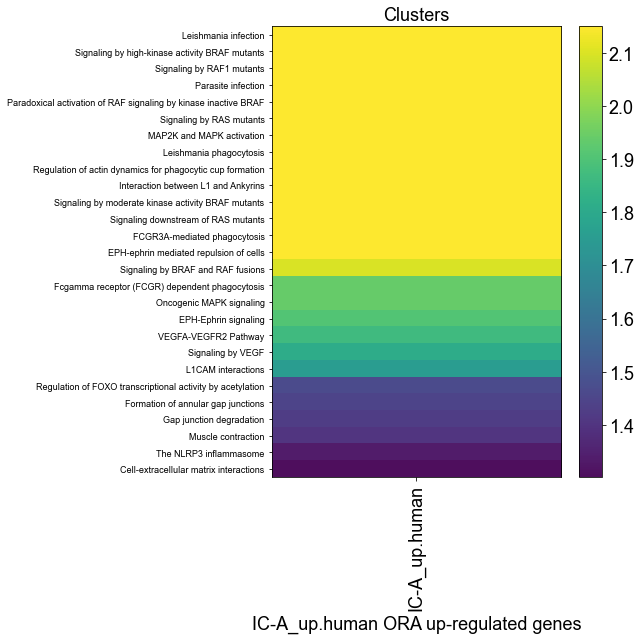

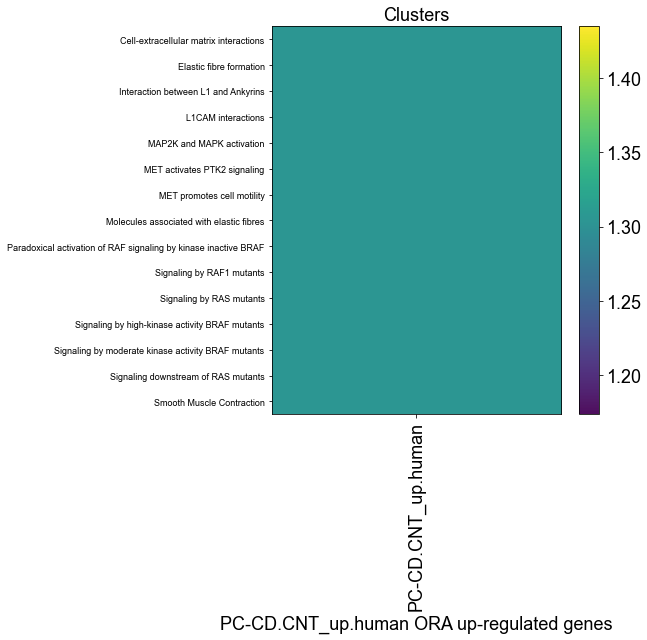

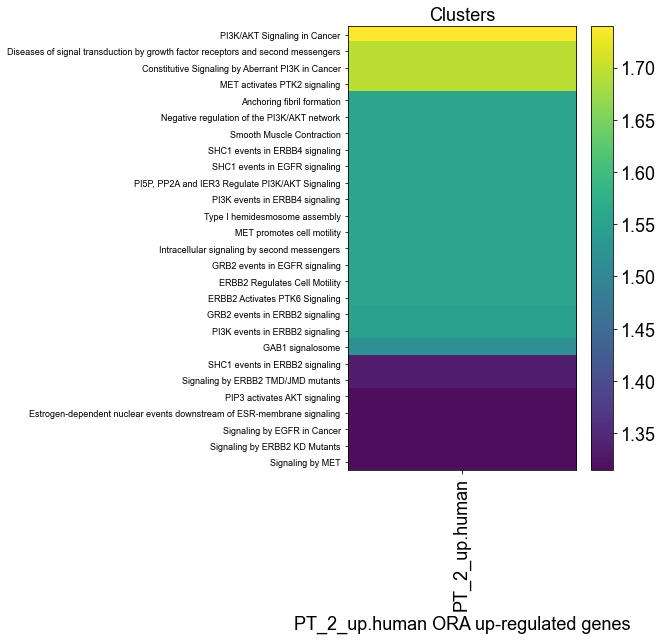

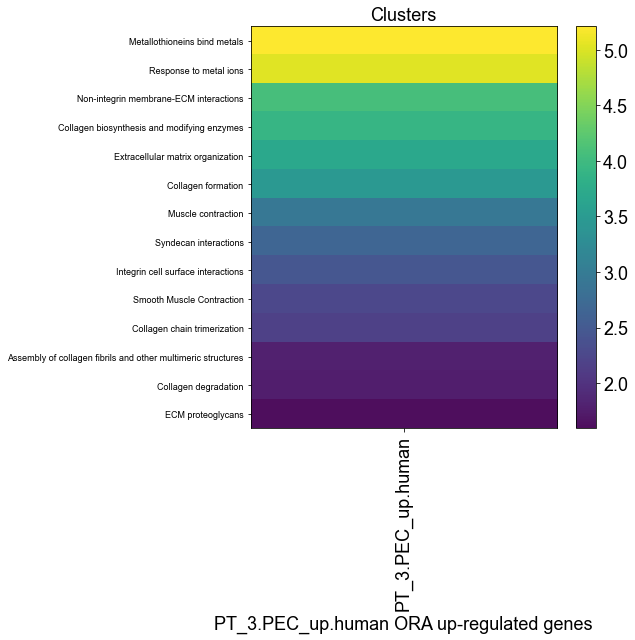

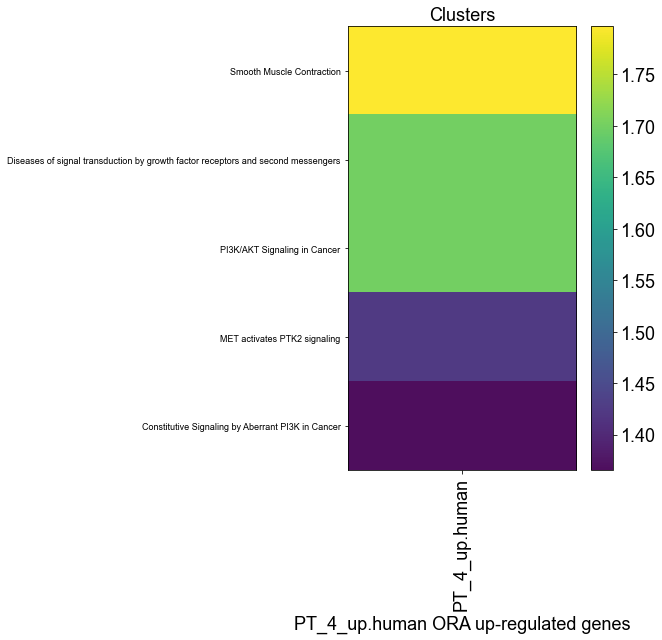

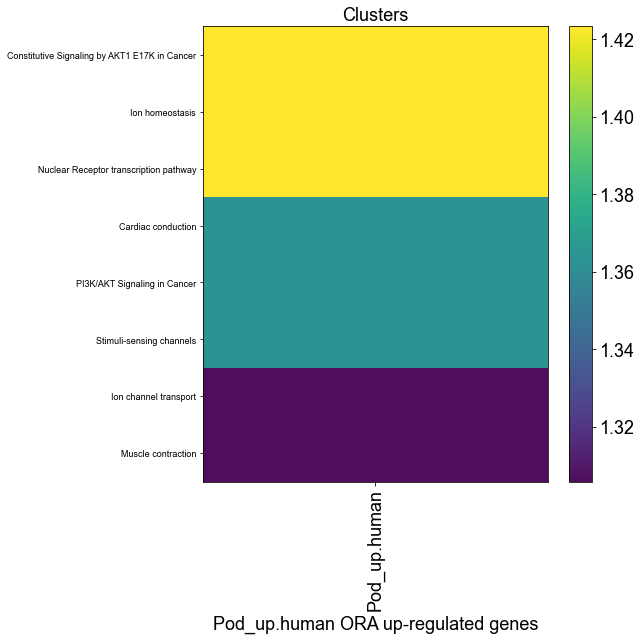

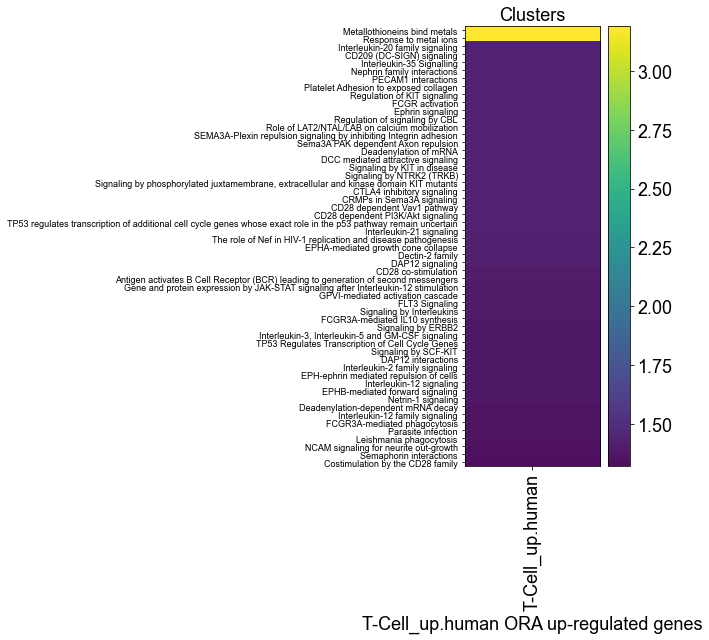

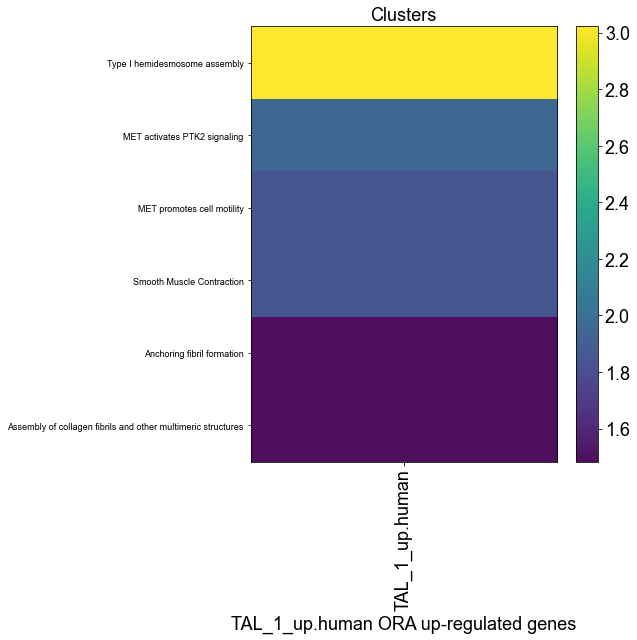

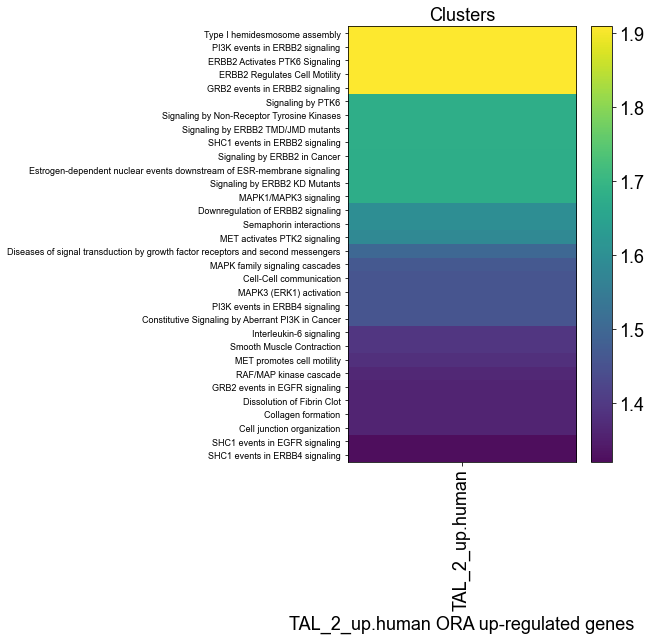

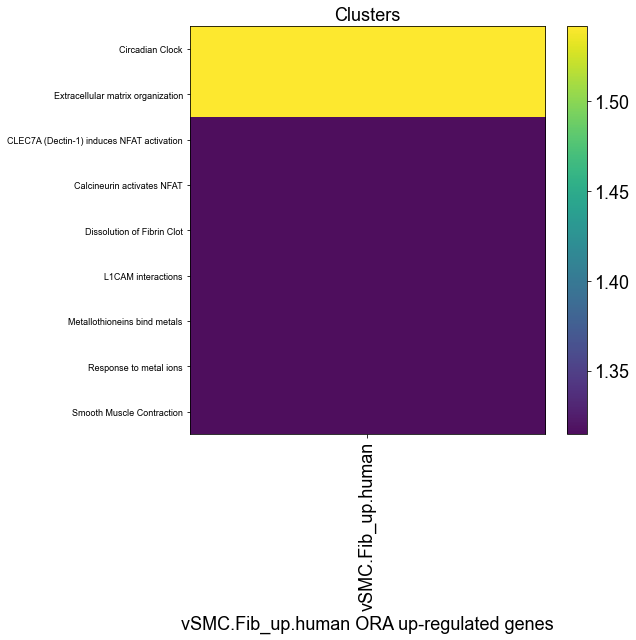

In [101]:
for name, mygrp in mygrps:
    print(name, mygrp.shape)
    plot_df = mygrp[["file_id", "Description", "neglog10"]]\
    .pivot(index='file_id', columns='Description', values='neglog10').fillna(0)
    
    ## Plot scores
    #print(plot_df)
    t_df = plot_df.T.reset_index().sort_values(by=name, ascending=False)
    
    t_df.set_index("Description", inplace=True)
    plot_df = t_df.T
    
    #print(plot_df.head())
    #sys.exit()
    
    mat = plot_df.to_numpy()

    #print(mat)
    plt.figure(figsize=(9, 9))

    plt.imshow(np.transpose(mat),cmap=plt.cm.get_cmap('viridis'), \
              alpha=0.95,interpolation='none', aspect='auto')#, vmin=0, vmax=1)

    plt.yticks(ticks=range(mat.shape[1]), labels=[s[0:] for s in plot_df.columns], rotation=0,fontsize=9)
    plt.xticks(ticks=range(mat.shape[0]), labels=[s[0:] for s in plot_df.index], rotation=90)
    plt.xlabel(name+' ORA up-regulated genes')

    plt.grid(None)   #<---- this should remove that white grid
    #plt.grid(color='w', linewidth=2)
    #plt.grid(which='minor', color='w', linestyle='-', linewidth=12)

    plt.colorbar()
    plt.title('Clusters')
    plt.tight_layout()
    
    plt.savefig(resulthome+name+"_up_ora.pdf")
    #plt.xgrid(color='w', linewidth=0)


    #plt.show()
    #sys.exit()

## Plot top 5 genes

In [603]:
select_de_genes_df = pd.concat(tmp_frames)

In [604]:
select_de_genes_df.head(2)

,Gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cell_id,file_id,comparison
181,MT1X,3.881305e-08,2.833102,0.615,0.000,0.000951,B-Cell,B-Cell,3xADPKD
238,REL,2.753763e-07,2.482384,0.611,0.077,0.006748,B-Cell,B-Cell,3xADPKD


In [616]:
tmp_adata.obs.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,Dissociation,S.Score,G2M.Score,Phase,RNA_snn_res.0.1,RNA_snn_res.0.2,...,init_assign,final_Ident,lab,orig.ident2,final_Ident2,ident,cluster_name,scrublet,treatment,cell_id
AAACCCAGTCACTGAT_1,ADPKD3_ADPKD3_kidney,1204.0,832,5.420267,0.066167,-0.024496,0.032604,G2M,0,0,...,Cyst.PT_1,Cyst.PT_1,Kramann,ADPKD3_ADPKD3_kidney,ADPKD3|Cyst.PT_1,3,3: TAL_2,0.161290,ADKPD,TAL_2
AAACCCAGTCTGTAAC_1,ADPKD3_ADPKD3_kidney,2482.0,1338,0.997208,-0.231793,-0.047692,0.109267,G2M,6,7,...,EC,EC,Kramann,ADPKD3_ADPKD3_kidney,ADPKD3|EC,5,5: EC,0.168207,ADKPD,EC


In [620]:
tmp_adata.obs["cell_id"] = tmp_adata.obs["cluster_name"].str.split(":").str[1].str.strip()

In [621]:
Counter(tmp_adata.obs["cell_id"])

Counter({'TAL_2': 2357,
         'EC': 1749,
         'TAL_1': 2385,
         'PC-CD/CNT': 4120,
         'B-Cell': 566,
         'Mac': 548,
         'PT_2': 1284,
         'DCT_1': 1852,
         'PT_1': 2849,
         'vSMC/Fib': 1187,
         'PT_4': 1638,
         'PT_3/PEC': 1716,
         'Unk_1': 130,
         'T-Cell': 1163,
         'IC-A': 1120,
         'Pod': 785,
         'Mast-Cell': 225,
         'IC-B': 545,
         'Unk_2': 32,
         'DCT_2': 258})

In [622]:
mygrps = select_de_genes_df.groupby("cell_id")

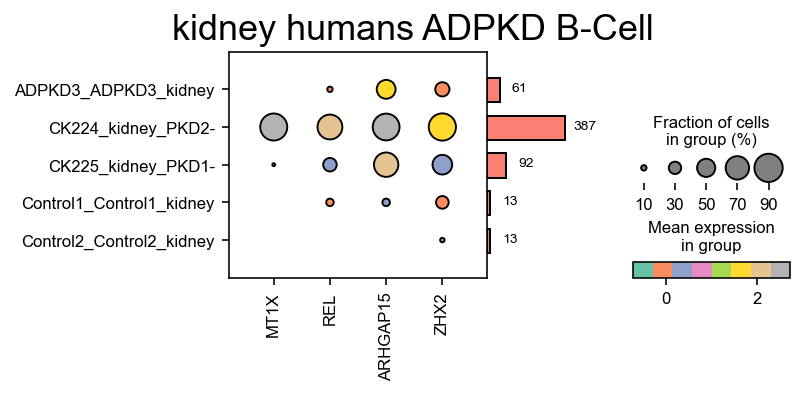

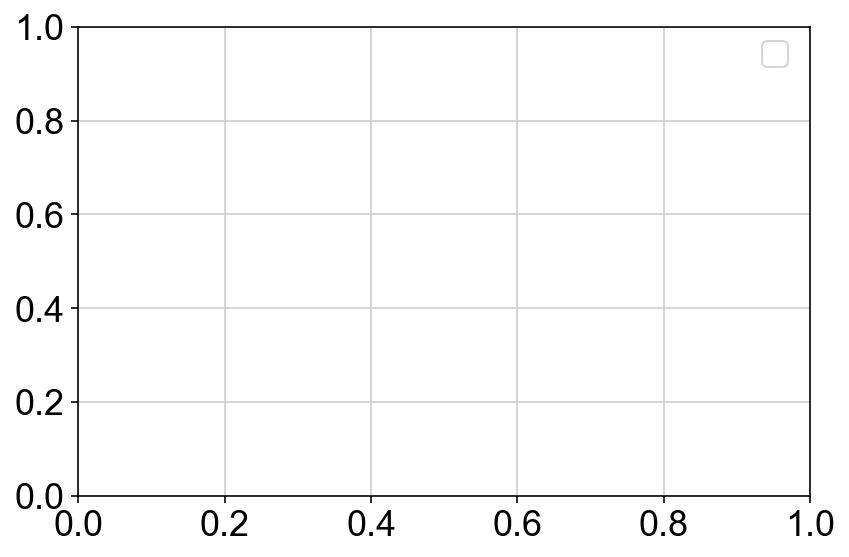

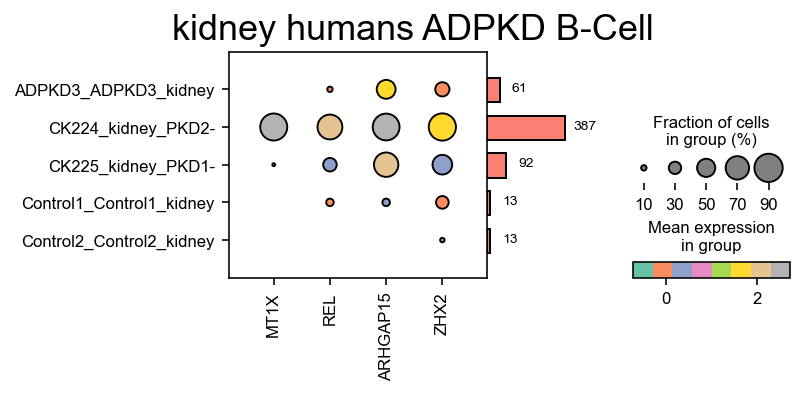

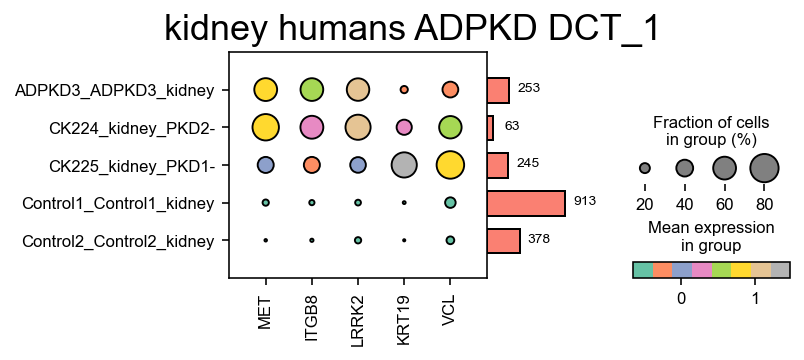

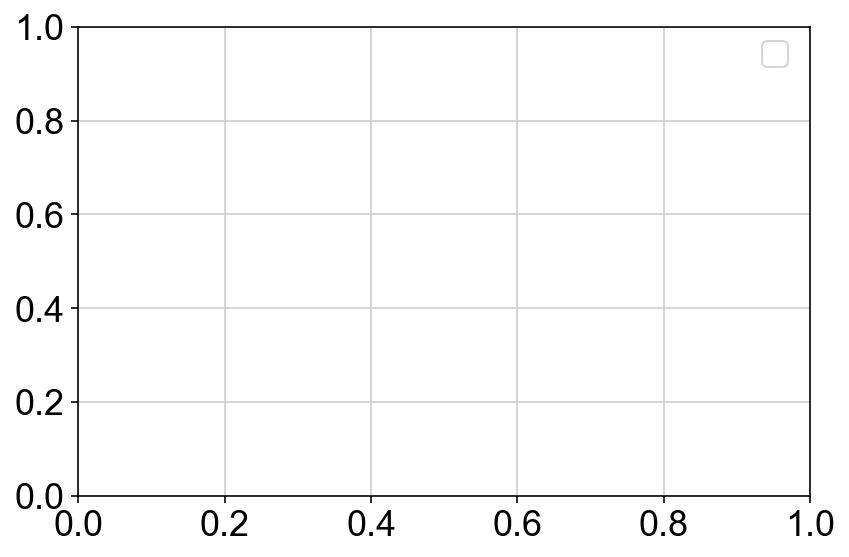

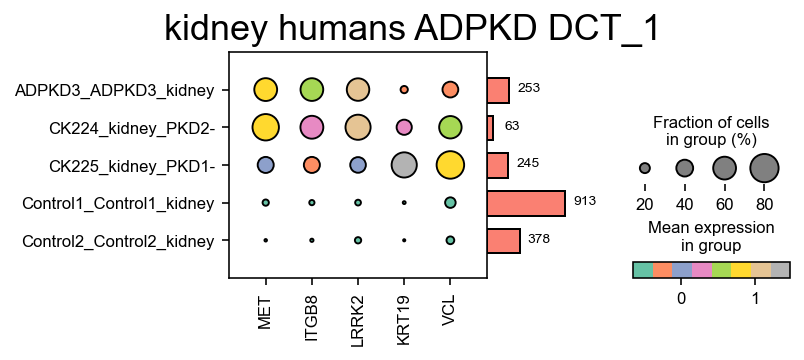

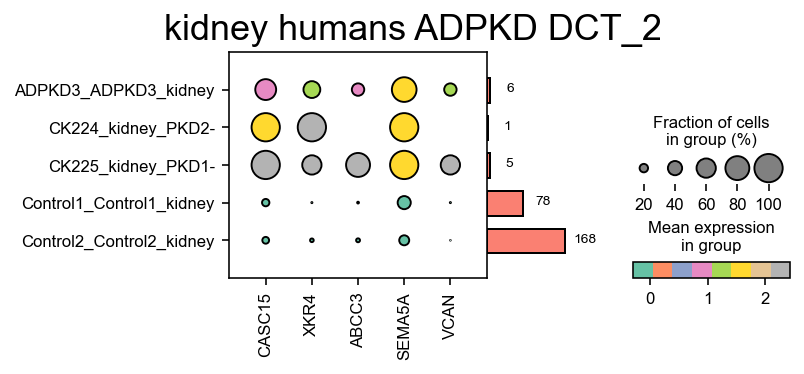

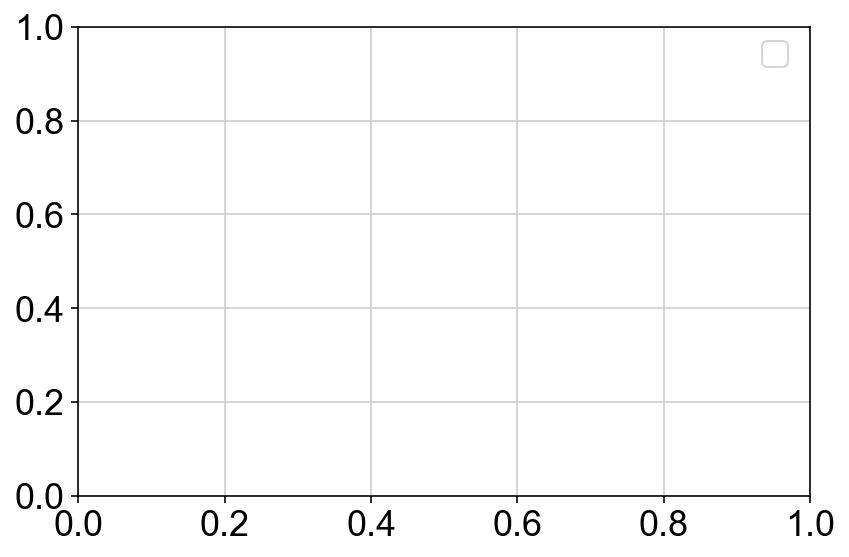

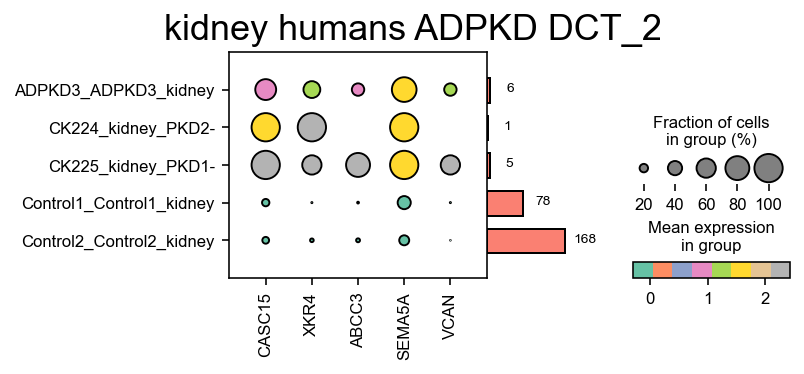

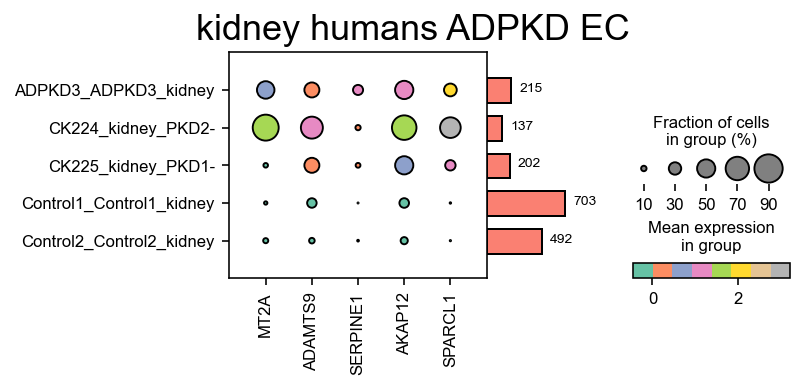

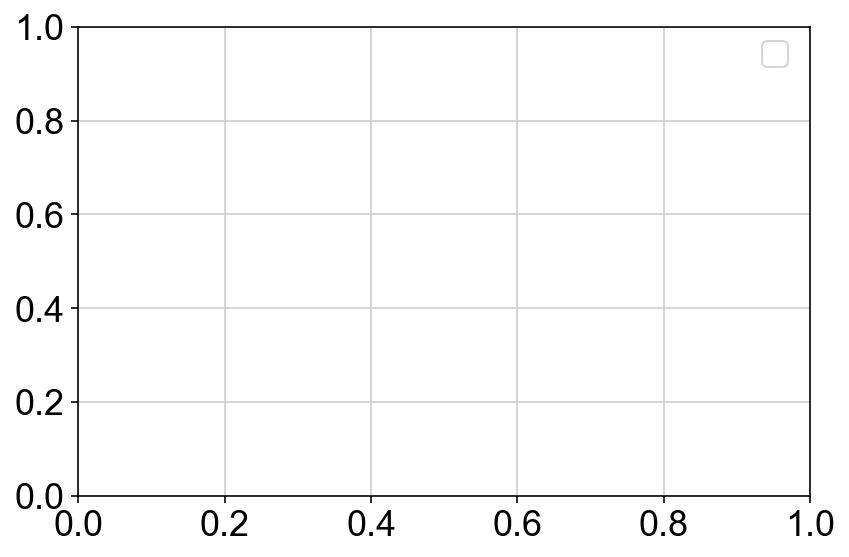

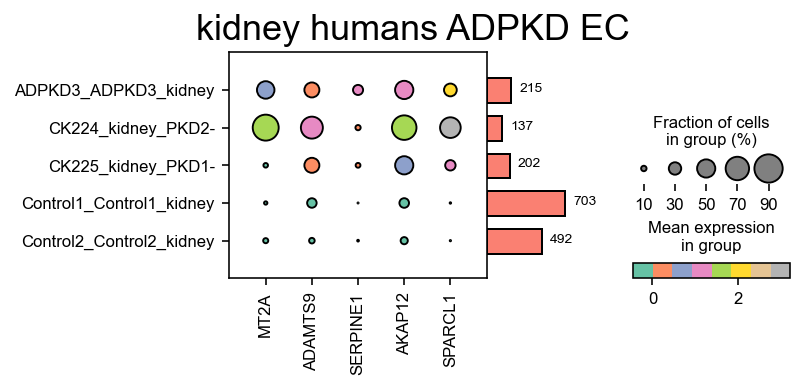

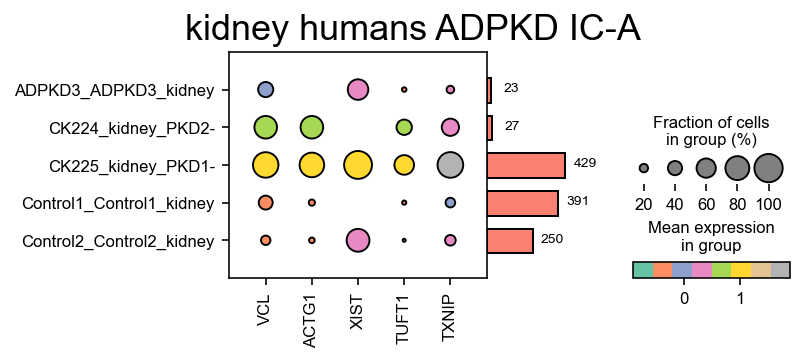

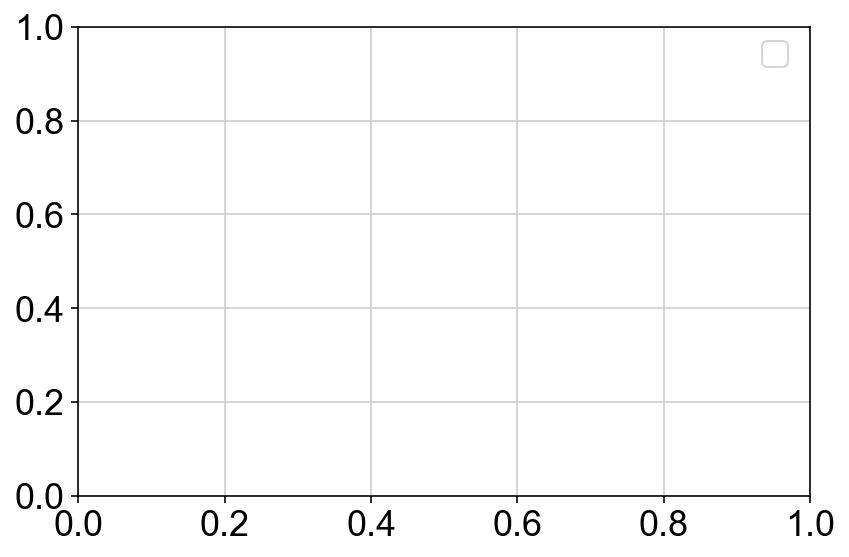

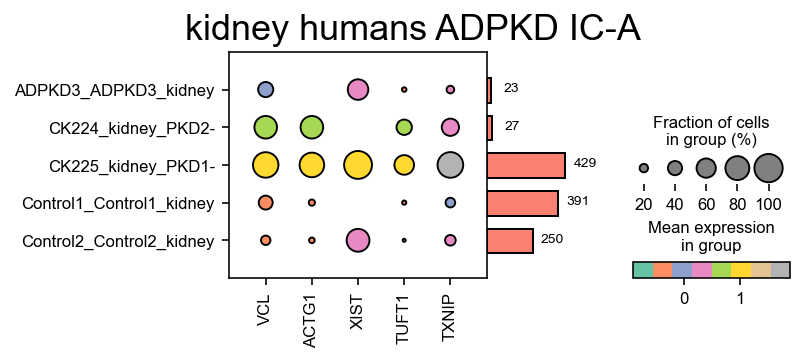

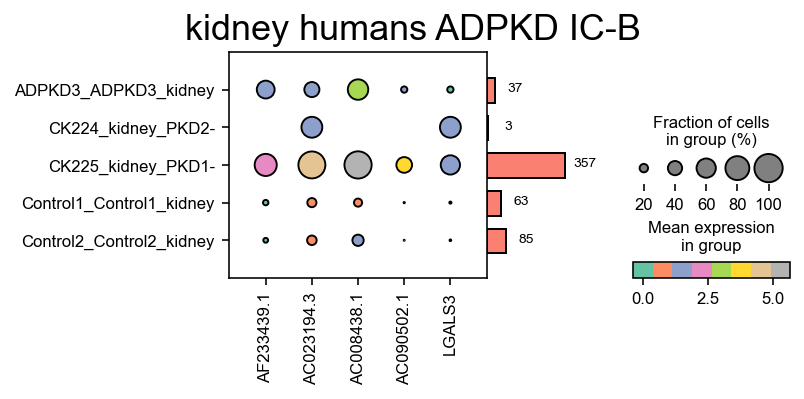

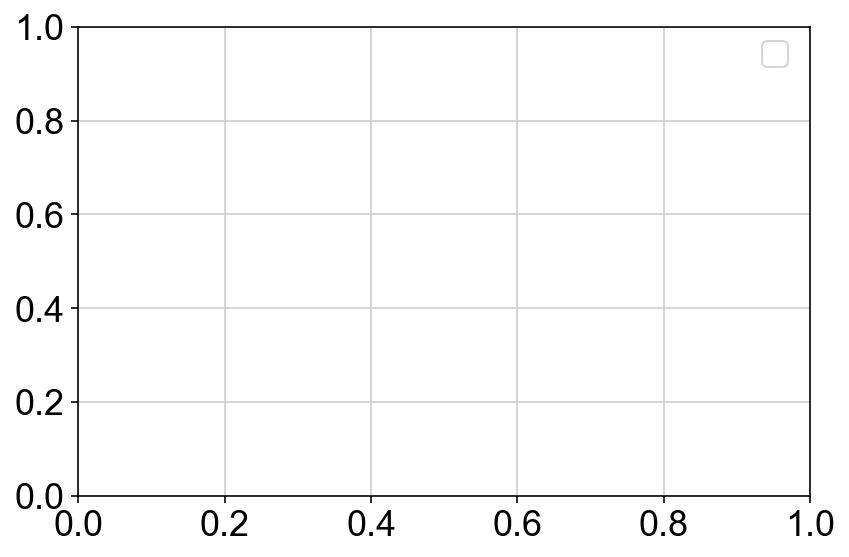

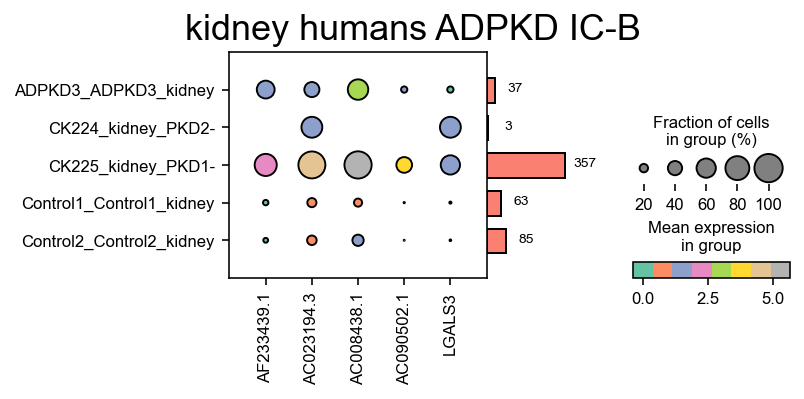

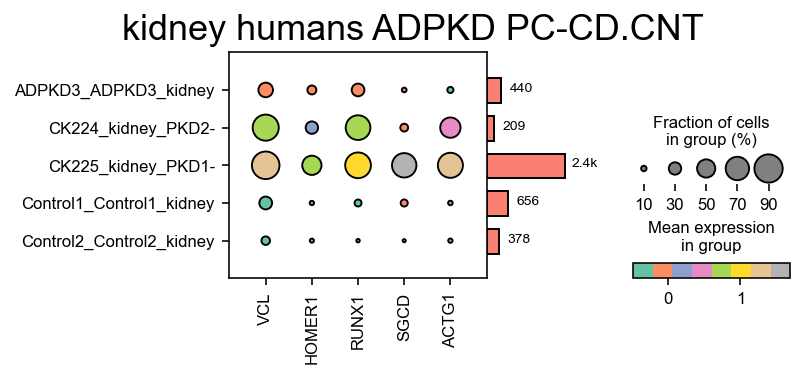

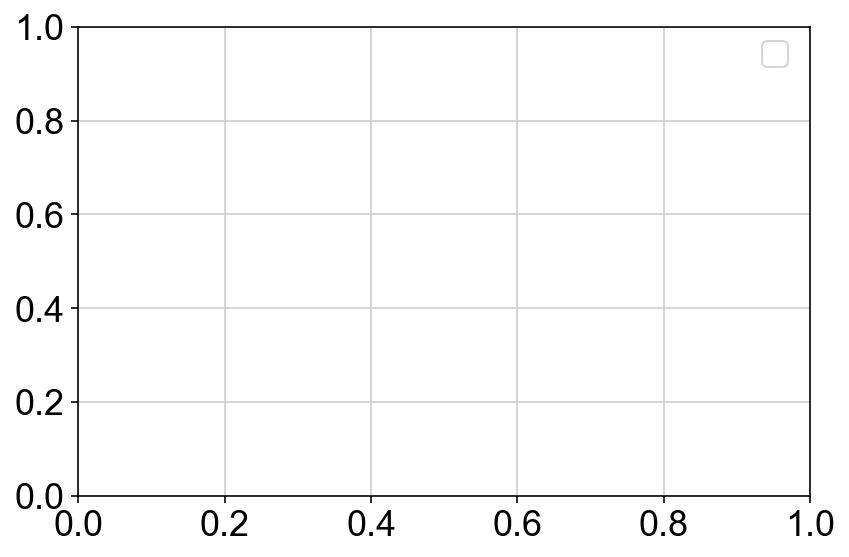

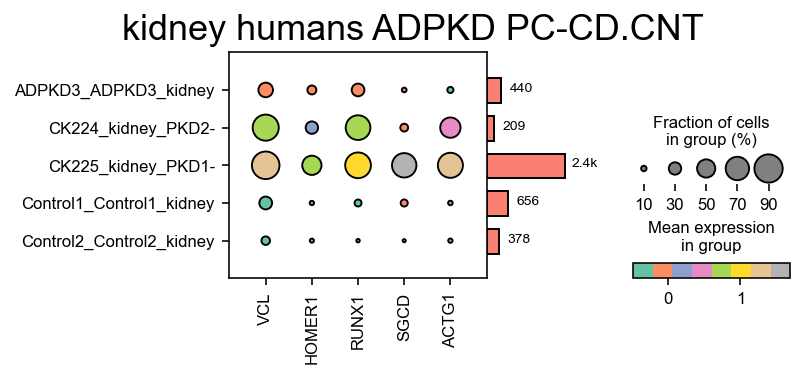

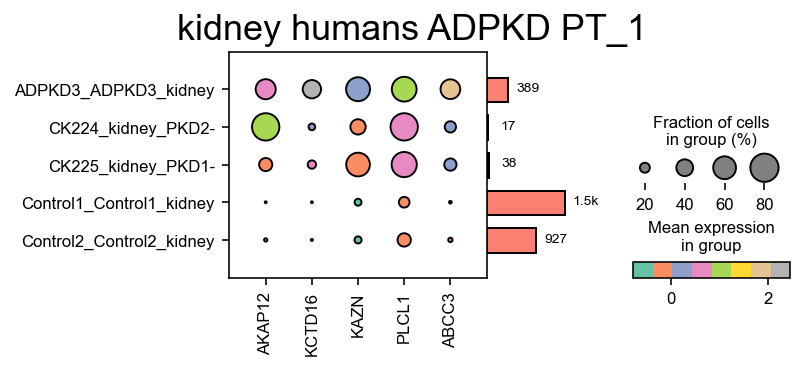

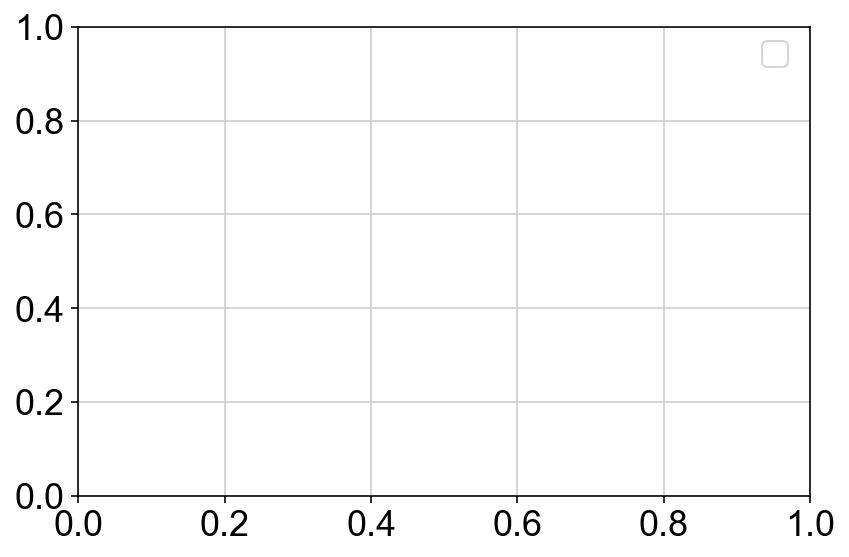

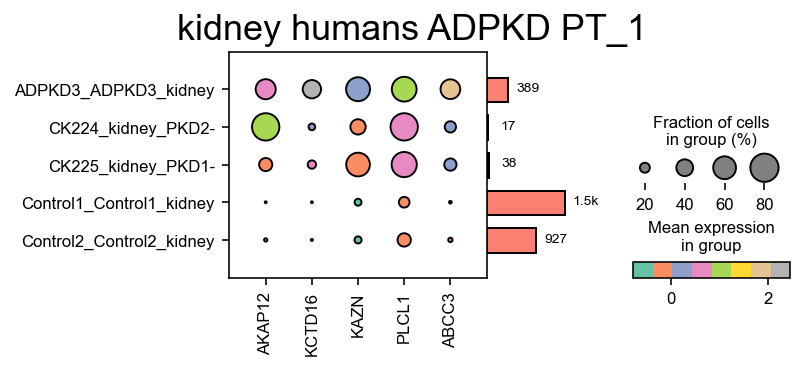

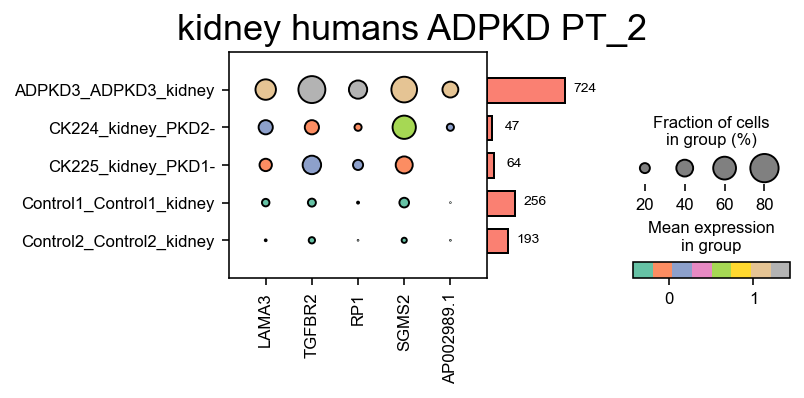

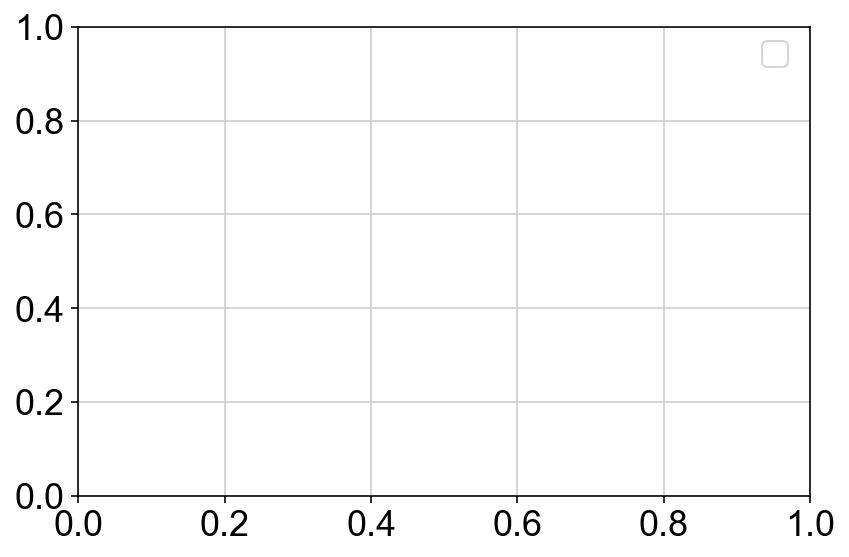

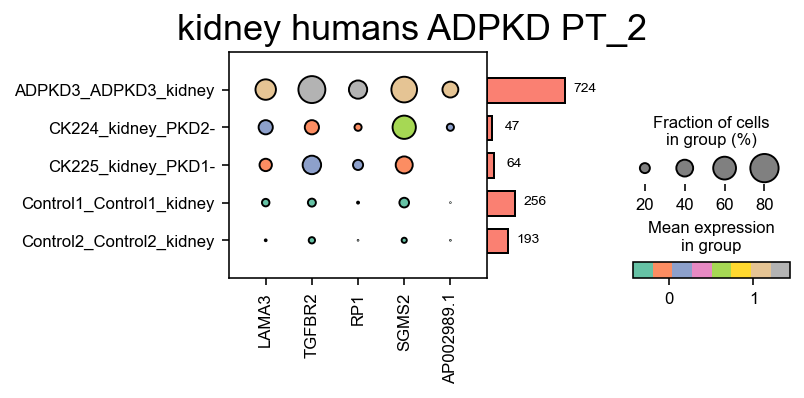

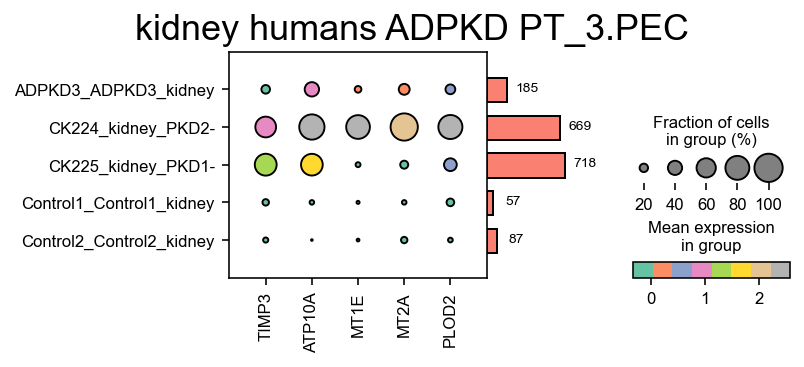

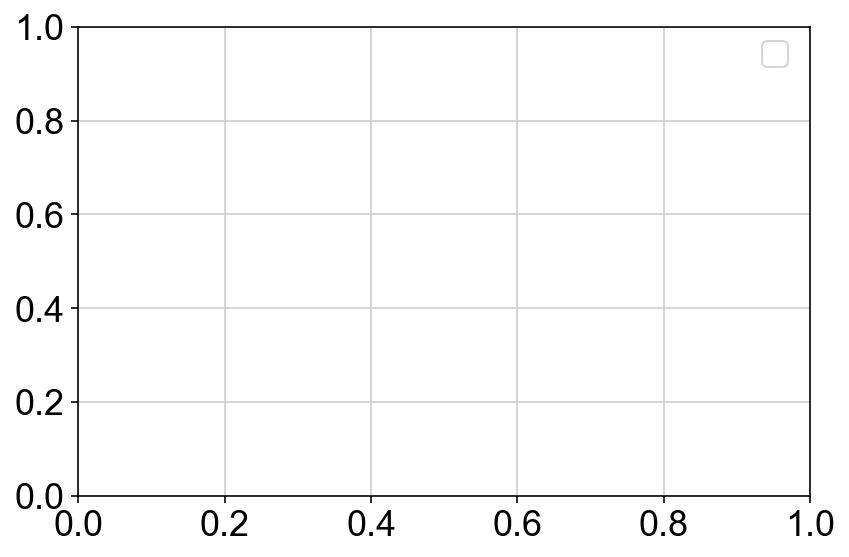

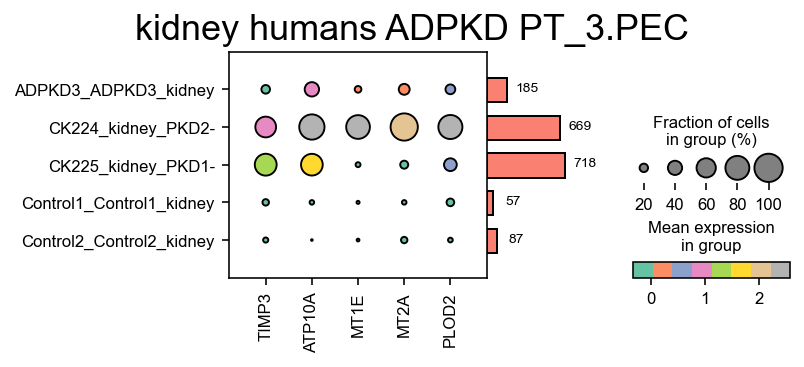

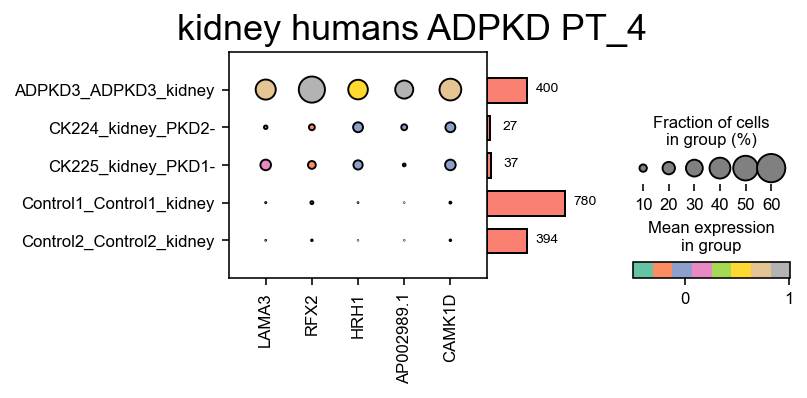

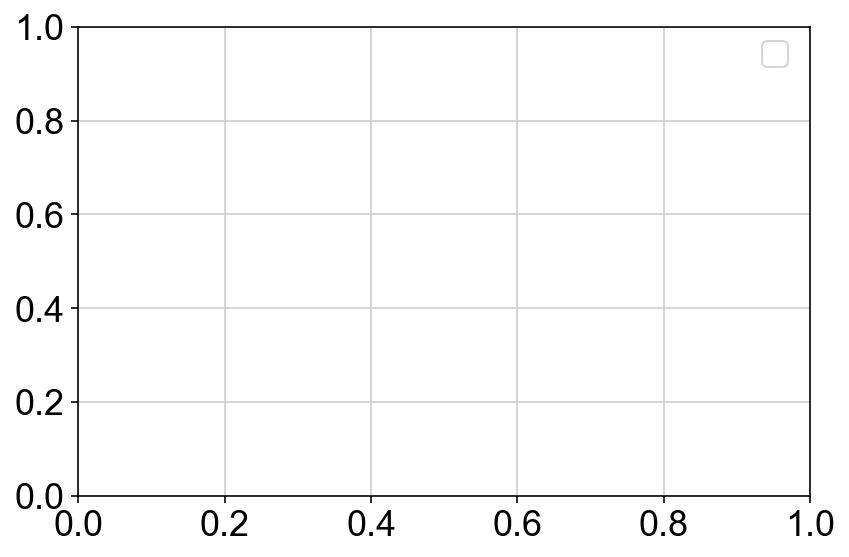

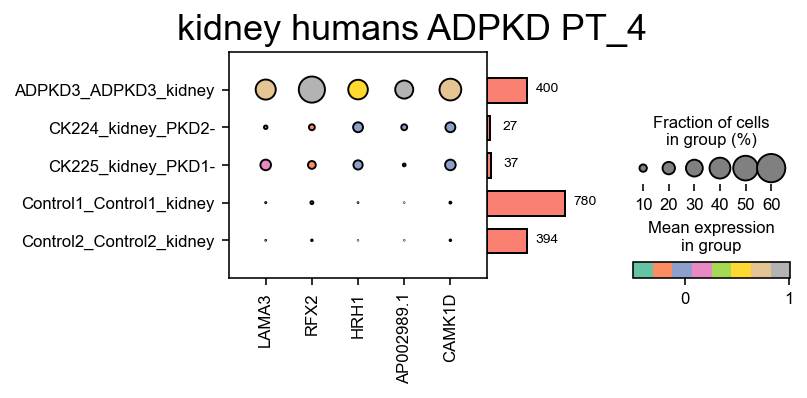

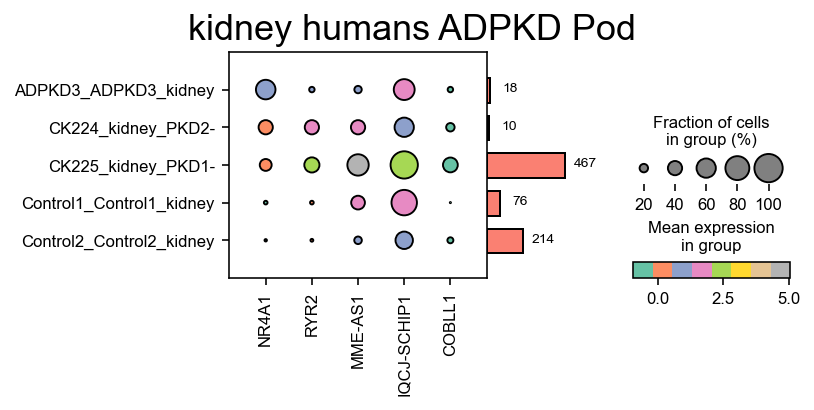

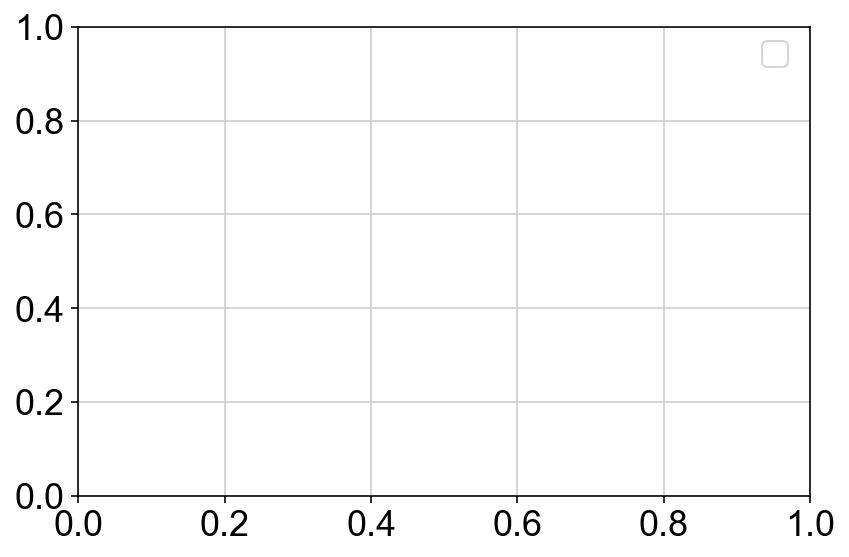

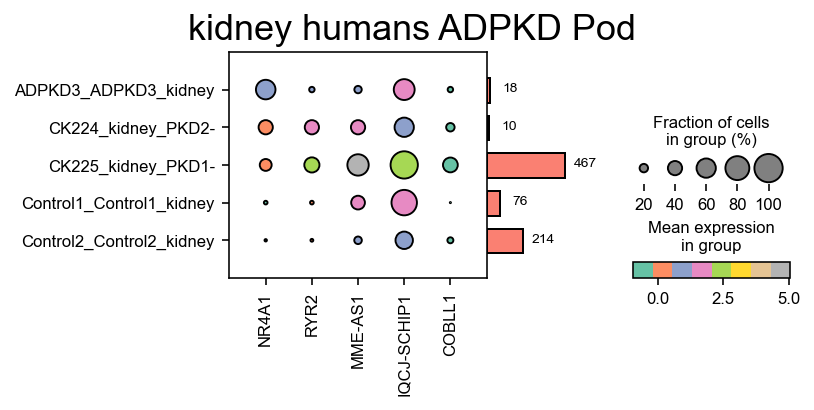

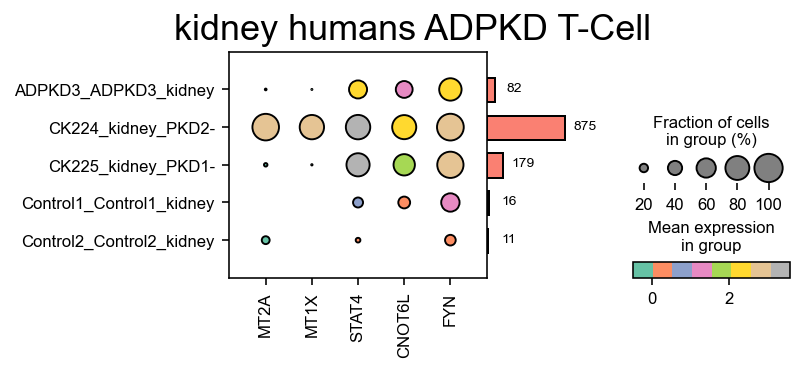

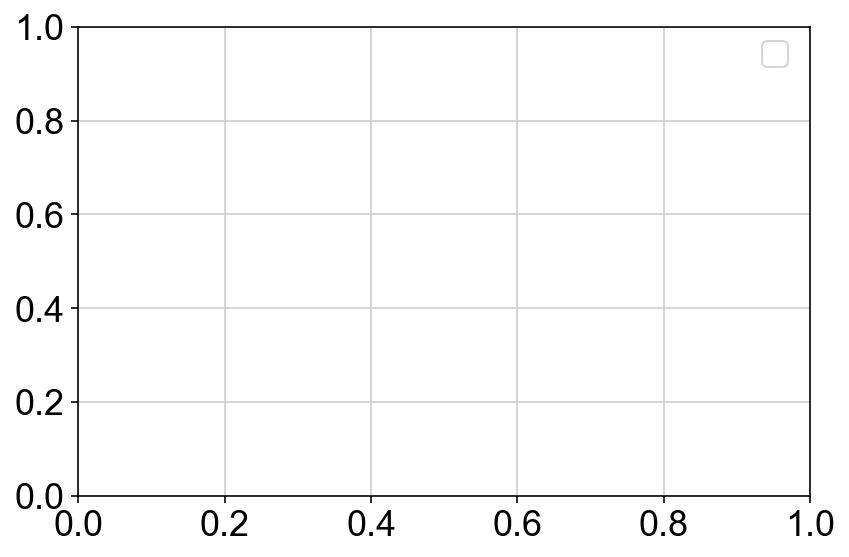

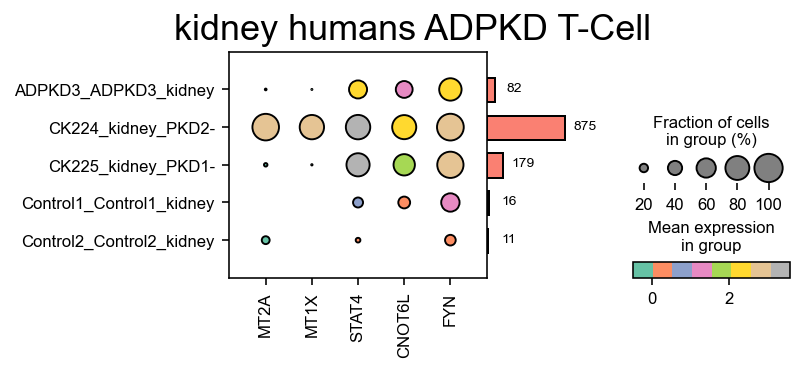

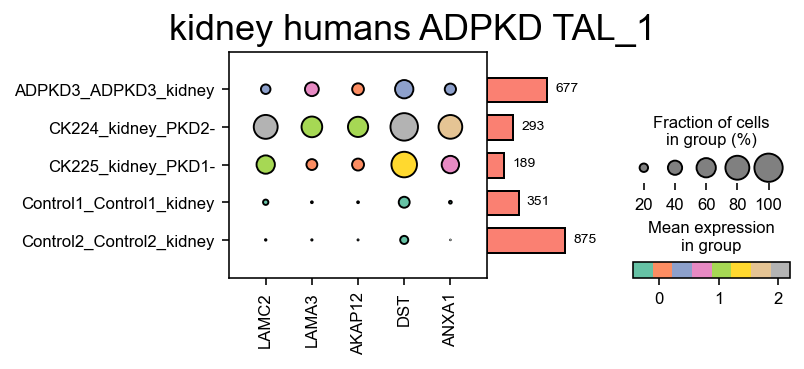

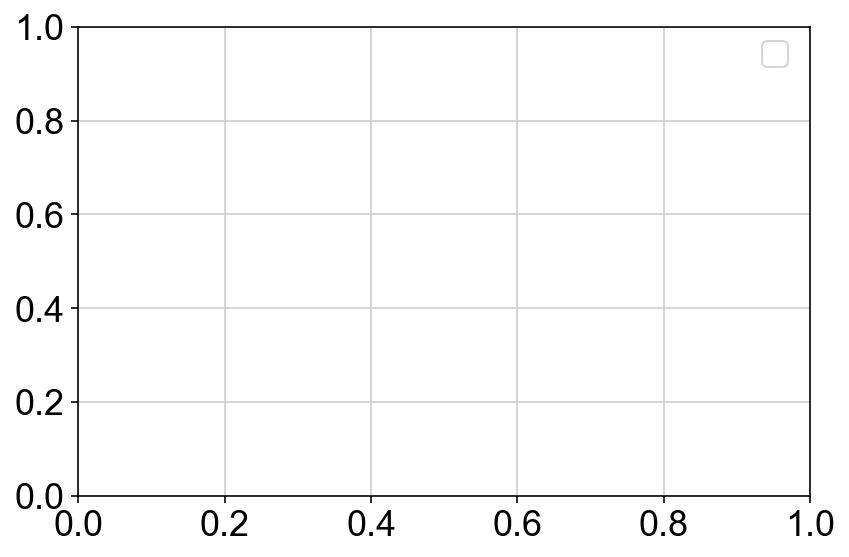

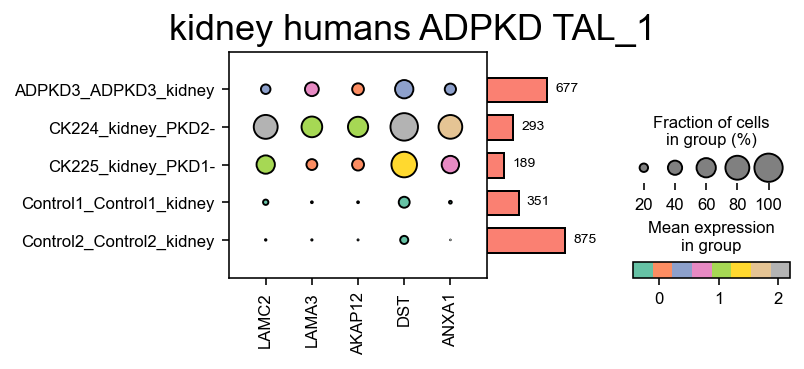

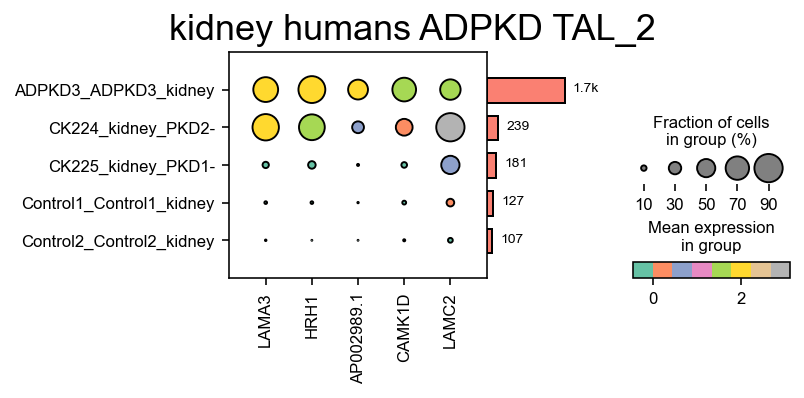

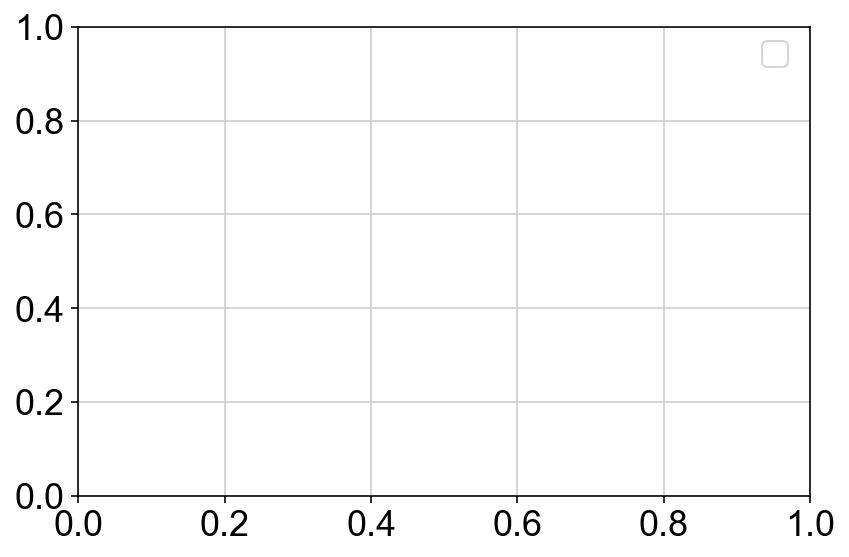

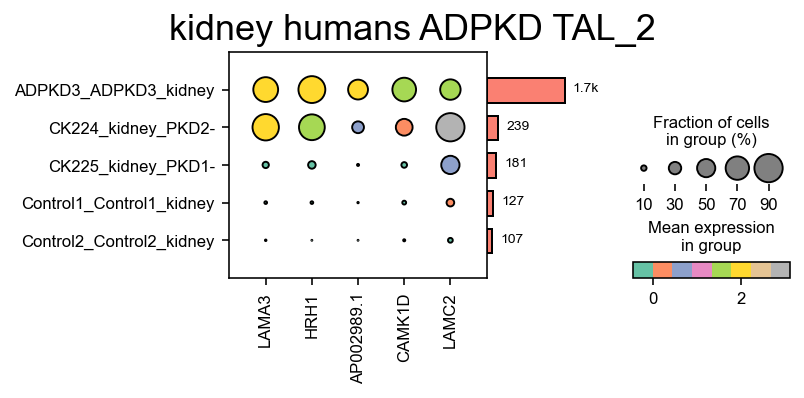

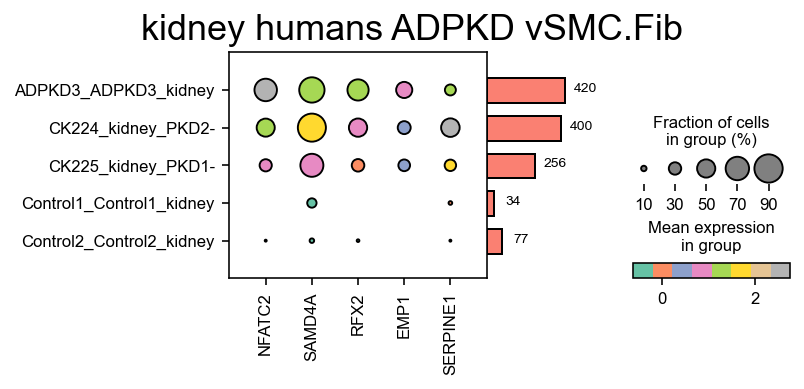

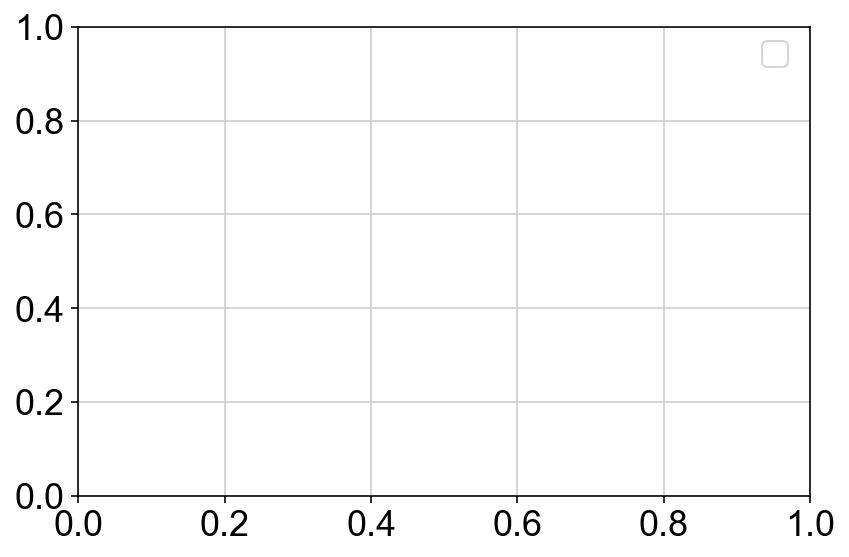

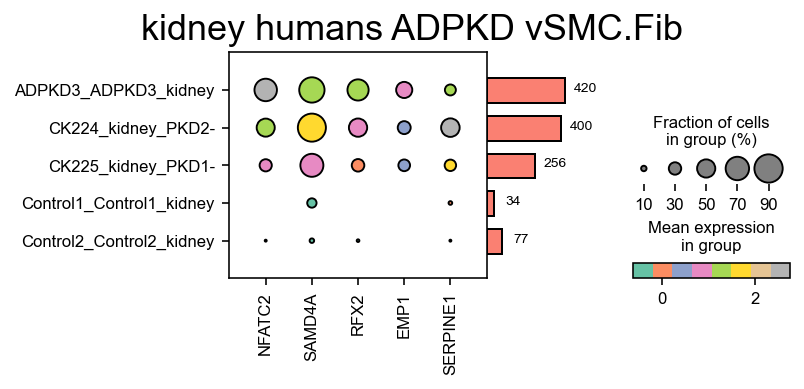

In [631]:
genelist = []
for name, mygrp in mygrps:
    print(name, mygrp.head(2))
    tmp_list = mygrp["Gene"].values.tolist()
    genelist.extend(tmp_list)
    
    mytitle  = "kidney humans ADPKD " + name

    dp = sc.pl.dotplot(tmp_adata[tmp_adata.obs["cell_id"]==name.replace(".","/")], tmp_list \
                           , figsize=(5, 2), title=mytitle  \
                           , groupby="orig.ident2", dendrogram=False,return_fig=True, show=False)

    dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.95, cmap="Set2").show()
    
    plt.legend(bbox_to_anchor=(0.97, 0.97), loc='upper right', ncol=2, borderaxespad=0)

    plt.tight_layout()
    #dp.savefig(resulthome+ name+"_adpkd_select_de_genes.pdf")

In [632]:
genelist = list(set(genelist))

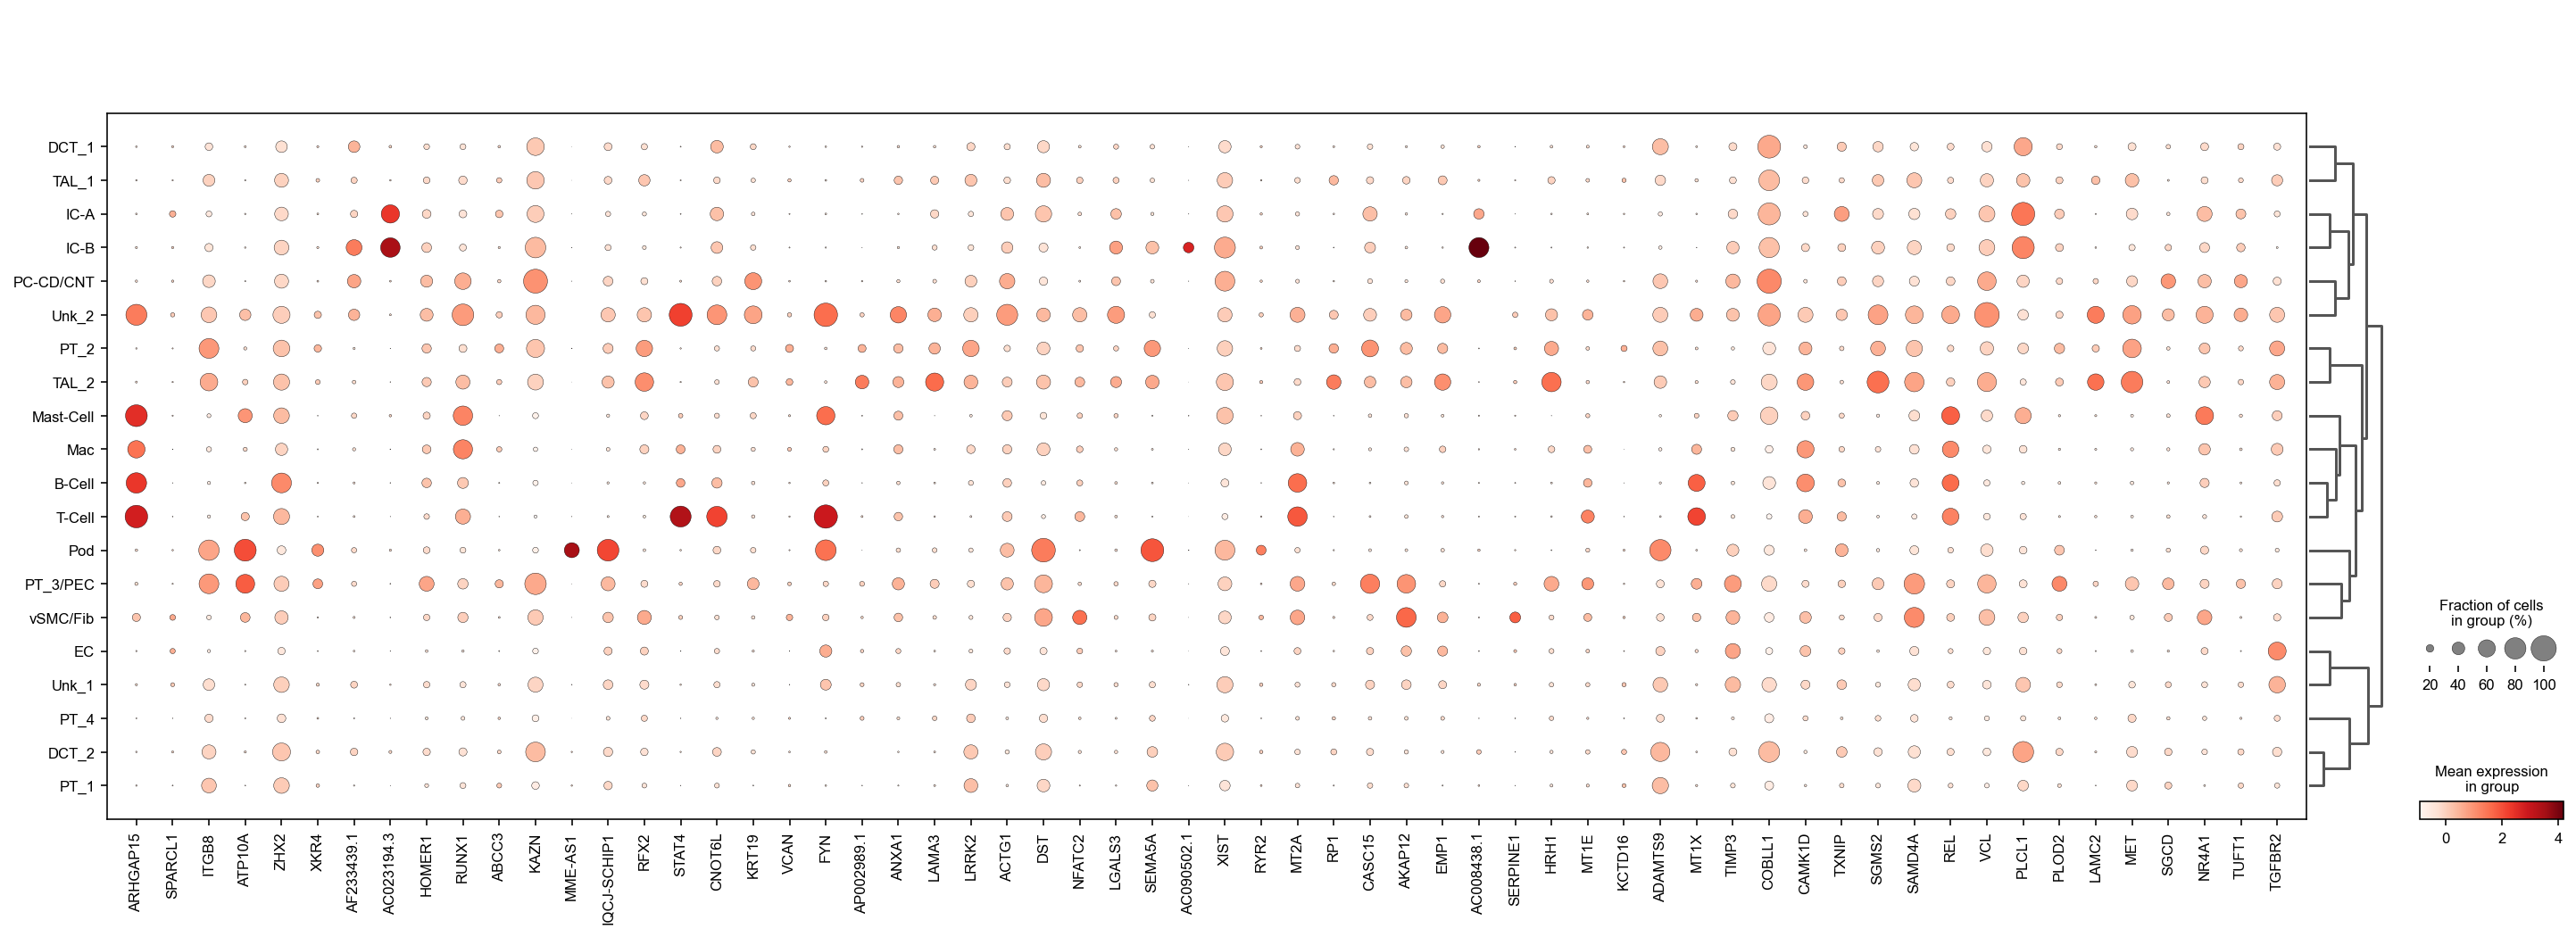

In [634]:
sc.pl.dotplot(tmp_adata, genelist, "cell_id", dendrogram=True)

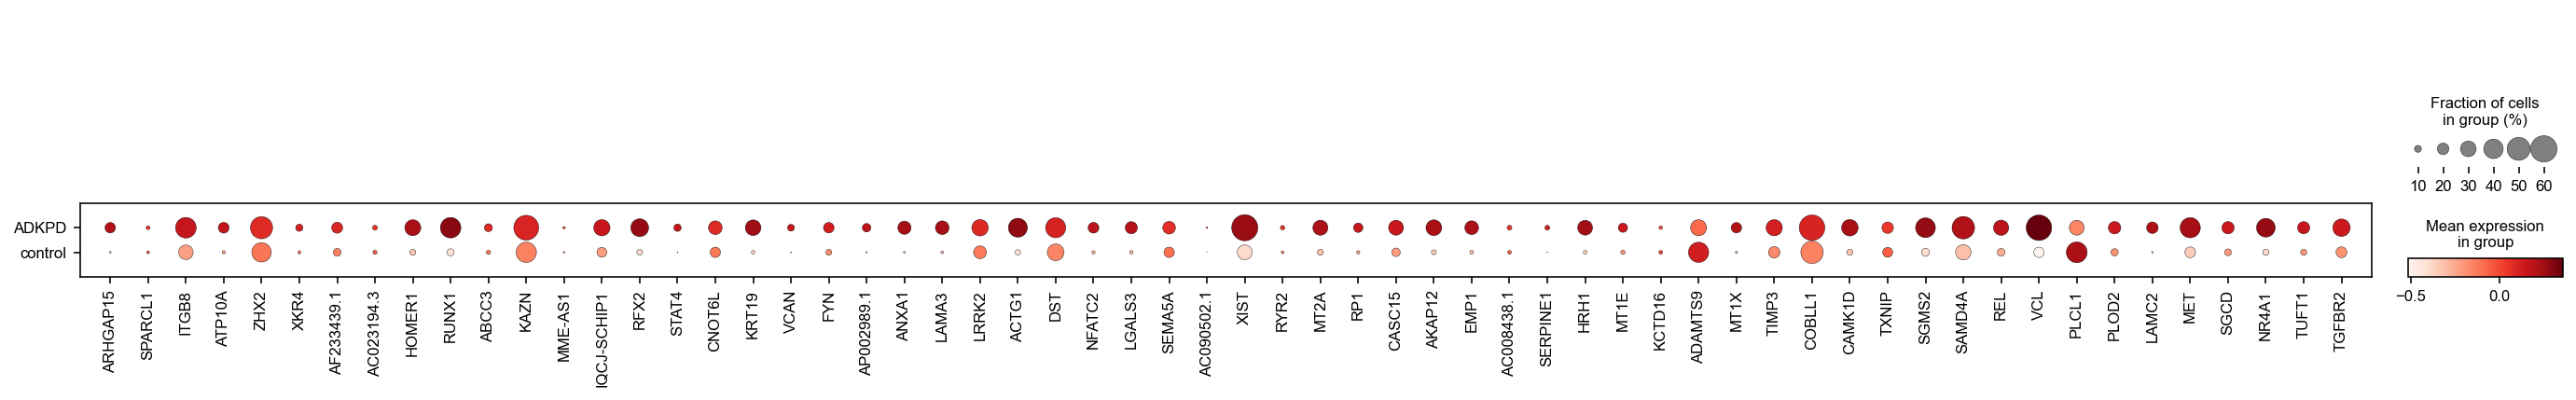

In [635]:
sc.pl.dotplot(tmp_adata, genelist, "treatment", dendrogram=True)

In [149]:
mygroup = selected_df.groupby("cell_id")

In [154]:
tmp_list = []
for name, grp in mygroup:
    mygenelist = grp.sort_values(by="avg_logFC", ascending=False).head()["Gene"].values.tolist()
    print(name, mygenelist)
    tmp_list.extend(mygenelist)
    
    tdf = pd.DataFrame(mygenelist, columns=["#gene"])
    tdf.to_csv(resulthome+ name+".genelist.ora", index=False)
    #print(grp.sort_values(by="avg_logFC", ascending=False)["Gene"].values.tolist())

B-Cell ['MT1X', 'REL', 'ARHGAP15', 'ZHX2']
DCT_1 ['SCN3A', 'PAPPA2', 'DACH1', 'TMTC2', 'ERBB4']
EC ['AKAP12', 'SPARCL1', 'EMP1', 'TACC1', 'ENPP2']
IC-A ['TUFT1', 'TXNIP', 'VAV3', 'SCN3A', 'SLC26A7']
IC-B ['AF233439.1', 'AC023194.3', 'AC008438.1', 'AC090502.1', 'LGALS3']
PT_1 ['KCTD16', 'SEMA5A', 'DLGAP1', 'KCNJ15', 'SATB2']
PT_2 ['LAMA3', 'TGFBR2', 'RP1', 'SGMS2', 'AP002989.1']
PT_4 ['LINC01320', 'UGT2B7']
Pod ['RYR2', 'MME-AS1', 'IQCJ-SCHIP1', 'AC008415.1', 'AC109466.1']
T-Cell ['MT2A', 'MT1X', 'STAT4', 'CNOT6L', 'FYN']
TAL_1 ['LAMC2', 'DST', 'ANXA1', 'AC096564.1', 'MET']
TAL_2 ['LAMA3', 'HRH1', 'AP002989.1', 'CAMK1D', 'LAMC2']


In [92]:
tmp_list = list(set(tmp_list))

In [93]:
print(tmp_list)

['ARHGAP15', 'SPARCL1', 'ZHX2', 'AF233439.1', 'AC023194.3', 'IQCJ-SCHIP1', 'MME-AS1', 'RFX2', 'STAT4', 'CNOT6L', 'ARRDC4', 'FYN', 'TMPRSS4', 'AP002989.1', 'LAMA3', 'ENPP2', 'LINC00621', 'SATB2', 'AC090502.1', 'BBOX1-AS1', 'FOXP2', 'RYR2', 'MT2A', 'AC109466.1', 'AC008438.1', 'SLC26A7', 'HRH1', 'KCNJ15', 'VWF', 'MT1X', 'CAMK1D', 'CCDC3', 'AC008415.1', 'REL', 'ZBTB20-AS5', 'LAMC2', 'RIPOR2', 'PAPPA2', 'ANO2', 'PRKX']
